In [1]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union, Callable


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from flwr.server.strategy import Strategy
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Status, GetParametersRes, Parameters, GetParametersIns, MetricsAggregationFn,NDArrays,Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.15.2 / PyTorch 2.6.0


In [3]:

BATCH_SIZE = 32
from flwr_datasets.partitioner import DirichletPartitioner
def load_datasets(partition_id, num_partitions: int):
    drichlet_partitioner = DirichletPartitioner(num_partitions=num_partitions, alpha=0.1, partition_by="label")
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": drichlet_partitioner})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MoonNet(nn.Module):
    """Returns both the representation (penultimate layer output) and classification"""
    def __init__(self) -> None:
        super(MoonNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        representation = x.clone()
        classification = self.fc3(x)
        return representation, classification

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        
def proxima_train(net, trainloader, epochs: int, proximal_mu:float, global_params:List[torch.Tensor]):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(images), labels) + (proximal_mu / 2) * proximal_term


            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def train_moon(net,train_loader, global_net,previous_net, epochs, mu, temperature):
    """Training function for MOON."""
    print(f"Started training moon")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    previous_net.eval()
    global_net.eval()

    cnt = 0
    cos = torch.nn.CosineSimilarity(dim=-1)

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for batch in train_loader:
            x, target = batch["img"], batch["label"]
            x, target = x.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()

            # pro1 is the representation by the current model (Line 14 of Algorithm 1)
            pro1, out = net(x)
            # pro2 is the representation by the global model (Line 15 of Algorithm 1)
            # pro3 is the representation by the previous model (Line 16 of Algorithm 1)
            with torch.no_grad():
                pro2, _ = global_net(x)
                pro3, _ = previous_net(x)

            # posi is the positive pair
            posi = cos(pro1, pro2)
            logits = posi.reshape(-1, 1)

            # nega is the negative pair
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1, 1)), dim=1)

            previous_net.to("cpu")
            logits /= temperature
            labels = torch.zeros(x.size(0)).to(DEVICE).long()

            # compute the model-contrastive loss (Line 17 of Algorithm 1)
            loss2 = mu * criterion(logits, labels)

            # compute the cross-entropy loss (Line 13 of Algorithm 1)
            loss1 = criterion(out, target)

            # compute the loss (Line 18 of Algorithm 1)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        print(
            "Epoch: %d Loss: %f Loss1: %f Loss2: %f"
            % (epoch, epoch_loss, epoch_loss1, epoch_loss2)
        )


def test_moon(net, testloader):
    """
    Evaluate the network on the entire test set.
    Same as the regular test, but using the MoonNet 
    (where the output is a tuple of (representation, classification) )
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            _, outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy




def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
        """Freeze specified layers of the model."""
        for idx, (name, param) in enumerate(model.named_parameters()):
            if idx == trainable_layers or trainable_layers == -1:
                param.requires_grad = True
            else:
                param.requires_grad = False

In [5]:

NETWORK_LEN = len(Net().state_dict().keys())
EPOCHS = 8
NUM_PARTITIONS = 6
NUM_OF_CYCLES  = 1
NUM_OF_FULL_UPDATES_BETWEEN_CYCLES = 5
NUM_OF_ROUNDS = (NUM_OF_CYCLES * NUM_OF_FULL_UPDATES_BETWEEN_CYCLES) + (NUM_OF_CYCLES * NETWORK_LEN *2)
print(f"Number of rounds: {NUM_OF_ROUNDS}")
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


Number of rounds: 25


In [6]:
from flwr.common import NDArrays, Scalar

def get_evaluate_fn(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate

# Normal FedAvg

In [7]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_avg_result = {}
fed_avg_model_results = {}

class ModifiedFedAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_avg_model_results:
            expand_fed_avg_result= {**fed_avg_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_avg_result= {"global_loss": loss, "global_metrics": metrics}

        fed_avg_model_results[server_round] = expand_fed_avg_result

        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        

        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_size": total_size}
        else:
            expand_fed_avg_result= {"total_size": total_size}

        fed_avg_result[server_round] = expand_fed_avg_result


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_avg_result= {"total_loss": total_loss}

        fed_avg_result[server_round] = expand_fed_avg_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [8]:
class NormalFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}



def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return NormalFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [9]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(
            evaluate_fn=evaluate_fn
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07214049396514892, {'accuracy': 0.0855}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 1] fit, config: {}


(ClientAppActor pid=80234) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80234)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80232) Epoch 1: train loss 0.05308206379413605, accuracy 0.3462646863223232
(ClientAppActor pid=80233) [Client 2] fit, config: {} [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=80235) Epoch 2: train loss 0.04009190946817398, accuracy 0.45186972255729796 [repeated 12x across cluster]
(ClientAppActor pid=80230) Epoch 6: train loss 0.017084157094359398, accuracy 0.7742200328407225 [repeated 12x across cluster]
(ClientAppActor pid=80233) Epoch 6: train loss 0.014279604889452457, accuracy 0.8269366945191899 [repeated 13x across cluster]
(ClientAppActor pid=80233) Epoch 8: train loss 0.012751996517181396, accuracy 0.8512958504461124 [repeated 6x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (1, 0.07245925214290619, {'accuracy': 0.1004}, 36.883561208989704)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80233) [Client 2] evaluate, config: {}
(ClientAppActor pid=80231) Epoch 8: train loss 0.01611107587814331, accuracy 0.8274597918637654 [repeated 4x across cluster]


(ClientAppActor pid=80233) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80233) [Client 4] fit, config: {}
(ClientAppActor pid=80232) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80234) Epoch 1: train loss 0.034117527306079865, accuracy 0.5231937602627258 [repeated 2x across cluster]
(ClientAppActor pid=80232) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80232) Epoch 2: train loss 0.03788584843277931, accuracy 0.46911942098914355 [repeated 12x across cluster]
(ClientAppActor pid=80235) Epoch 7: train loss 0.034678664058446884, accuracy 0.5872312125914432 [repeated 13x across cluster]
(ClientAppActor pid=80230) Epoch 7: train loss 0.014729328453540802, accuracy 0.8495887191539365 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80232) Epoch 8: train loss 0.03053484670817852, accuracy 0.5843184559710495 [repeated 8x across cluster]


INFO :      fit progress: (2, 0.07466554532051087, {'accuracy': 0.1}, 69.5677092919941)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80232) [Client 1] evaluate, config: {}


(ClientAppActor pid=80232) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80232)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80232) [Client 5] fit, config: {}
(ClientAppActor pid=80233) Epoch 8: train loss 0.017536010593175888, accuracy 0.8080652790917692
(ClientAppActor pid=80232) Epoch 1: train loss 0.03166728839278221, accuracy 0.49117405582922824
(ClientAppActor pid=80235) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80235) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80234) Epoch 2: train loss 0.03667209669947624, accuracy 0.47539203860072377 [repeated 12x across cluster]
(ClientAppActor pid=80235) Epoch 6: train loss 0.03489402309060097, accuracy 0.5894480159609843 [repeated 11x across cluster]
(ClientAppActor pid=80233) Epoch 6: train loss 0.015546378679573536, accuracy 0.8401880141010576 [repeated 13x across cluster]
(ClientAppActor pid=80234) Epoch 7: train loss 0.03154853358864784, accuracy 0.5634499396863691 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (3, 0.07073091124296188, {'accuracy': 0.1212}, 103.90684912499273)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=80231) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80231)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80231) [Client 3] evaluate, config: {}
(ClientAppActor pid=80230) Epoch 8: train loss 0.017477767542004585, accuracy 0.8085383159886471 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80232) [Client 4] fit, config: {}
(ClientAppActor pid=80233) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80235) Epoch 1: train loss 0.05035656690597534, accuracy 0.37308800709377077
(ClientAppActor pid=80230) Epoch 1: train loss 0.03885264694690704, accuracy 0.6035546415981199
(ClientAppActor pid=80231) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80235) Epoch 4: train loss 0.03780528903007507, accuracy 0.553314121037464 [repeated 13x across cluster]
(ClientAppActor pid=80235) Epoch 7: train loss 0.03485456109046936, accuracy 0.5956550653956995 [repeated 12x across cluster]
(ClientAppActor pid=80230) Epoch 7: train loss 0.014909169636666775, accuracy 0.8467978848413631 [repeated 12x across cluster]
(ClientAppActor pid=80233) Epoch 8: train loss 0.02973652444779873, accuracy 0.603015681544029 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (4, 0.07183133164644241, {'accuracy': 0.1191}, 136.61316162499133)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80232) [Client 0] evaluate, config: {}


(ClientAppActor pid=80232) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80232)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80230) [Client 5] fit, config: {}
(ClientAppActor pid=80232) Epoch 8: train loss 0.018660226836800575, accuracy 0.7968306527909177
(ClientAppActor pid=80230) Epoch 1: train loss 0.02995777688920498, accuracy 0.5453612479474549
(ClientAppActor pid=80235) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80231) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80232) Epoch 2: train loss 0.022243186831474304, accuracy 0.7635998107852412 [repeated 12x across cluster]
(ClientAppActor pid=80233) Epoch 7: train loss 0.03441799059510231, accuracy 0.6011970738195522 [repeated 14x across cluster]
(ClientAppActor pid=80235) Epoch 7: train loss 0.01472647488117218, accuracy 0.8460634547591069 [repeated 12x across cluster]
(ClientAppActor pid=80232) Epoch 8: train loss 0.016688227653503418, accuracy 0.8248580889309366 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (5, 0.08001001871824265, {'accuracy': 0.1204}, 169.13776716700522)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 2] evaluate, config: {}


(ClientAppActor pid=80233) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 4] fit, config: {}
(ClientAppActor pid=80231) Epoch 8: train loss 0.028276076540350914, accuracy 0.6226779252110977
(ClientAppActor pid=80233) Epoch 1: train loss 0.02585856430232525, accuracy 0.6397783251231527
(ClientAppActor pid=80232) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80232) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80232) Epoch 2: train loss 0.0327560156583786, accuracy 0.5525934861278649 [repeated 13x across cluster]
(ClientAppActor pid=80234) Epoch 4: train loss 0.018839513882994652, accuracy 0.8049905392620624 [repeated 13x across cluster]
(ClientAppActor pid=80230) Epoch 7: train loss 0.015369751490652561, accuracy 0.843566392479436 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80234) Epoch 8: train loss 0.015809273347258568, accuracy 0.8318353831598865 [repeated 8x across cluster]


INFO :      fit progress: (6, 0.06786979311704636, {'accuracy': 0.1638}, 201.0888900840073)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80232) [Client 0] evaluate, config: {}


(ClientAppActor pid=80232) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80232)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80232) [Client 5] fit, config: {}
(ClientAppActor pid=80232) Epoch 8: train loss 0.027065660804510117, accuracy 0.6379975874547648
(ClientAppActor pid=80232) Epoch 1: train loss 0.03327365964651108, accuracy 0.5260673234811166
(ClientAppActor pid=80233) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80230) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80230) Epoch 4: train loss 0.03465916961431503, accuracy 0.6034138771890933 [repeated 14x across cluster]
(ClientAppActor pid=80230) Epoch 7: train loss 0.031020691618323326, accuracy 0.6473065839060075 [repeated 12x across cluster]
(ClientAppActor pid=80231) Epoch 7: train loss 0.013706638477742672, accuracy 0.8591363102232668 [repeated 12x across cluster]
(ClientAppActor pid=80233) Epoch 8: train loss 0.02537097968161106, accuracy 0.6720144752714113 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (7, 0.06823713128566741, {'accuracy': 0.1777}, 232.33877274999395)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 0] evaluate, config: {}


(ClientAppActor pid=80232) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80232)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 3] fit, config: {}
(ClientAppActor pid=80234) Epoch 8: train loss 0.015005074441432953, accuracy 0.8359744560075686
(ClientAppActor pid=80234) Epoch 1: train loss 0.04931351915001869, accuracy 0.3959210818000443
(ClientAppActor pid=80231) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80231) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80234) Epoch 4: train loss 0.03237787261605263, accuracy 0.6317889603192197 [repeated 14x across cluster]
(ClientAppActor pid=80234) Epoch 7: train loss 0.02889341488480568, accuracy 0.6657060518731989 [repeated 12x across cluster]
(ClientAppActor pid=80231) Epoch 7: train loss 0.013772056438028812, accuracy 0.8559048178613397 [repeated 12x across cluster]
(ClientAppActor pid=80233) Epoch 8: train loss 0.023597566410899162, accuracy 0.6990349819059107 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (8, 0.06413321546316147, {'accuracy': 0.2355}, 263.19179520898615)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80233) [Client 1] evaluate, config: {}


(ClientAppActor pid=80233) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80230) [Client 3] fit, config: {}
(ClientAppActor pid=80232) Epoch 8: train loss 0.014680389314889908, accuracy 0.8446073793755913
(ClientAppActor pid=80230) Epoch 1: train loss 0.044075895100831985, accuracy 0.4712923963644425
(ClientAppActor pid=80231) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80232) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80230) Epoch 4: train loss 0.02970883809030056, accuracy 0.6590556417645754 [repeated 14x across cluster]
(ClientAppActor pid=80230) Epoch 7: train loss 0.026447022333741188, accuracy 0.6985147417424075 [repeated 12x across cluster]
(ClientAppActor pid=80235) Epoch 7: train loss 0.012910964898765087, accuracy 0.8676556991774383 [repeated 12x across cluster]
(ClientAppActor pid=80231) Epoch 8: train loss 0.021825291216373444, accuracy 0.7225572979493365 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (9, 0.06615628101825714, {'accuracy': 0.1951}, 294.1781079999928)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 4] evaluate, config: {}


(ClientAppActor pid=80234) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80234)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 4] fit, config: {}
(ClientAppActor pid=80233) Epoch 8: train loss 0.014209519140422344, accuracy 0.8478003784295175
(ClientAppActor pid=80230) Epoch 1: train loss 0.022641118615865707, accuracy 0.7173645320197044
(ClientAppActor pid=80231) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80235) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80233) Epoch 4: train loss 0.030311765149235725, accuracy 0.6470849035690535 [repeated 14x across cluster]
(ClientAppActor pid=80233) Epoch 7: train loss 0.026282869279384613, accuracy 0.69164265129683 [repeated 12x across cluster]
(ClientAppActor pid=80232) Epoch 7: train loss 0.012491739355027676, accuracy 0.8694183313748531 [repeated 12x across cluster]
(ClientAppActor pid=80231) Epoch 8: train loss 0.020611286163330078, accuracy 0.7433051869722558 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (10, 0.06545526435375214, {'accuracy': 0.2186}, 325.4872041250055)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 0] evaluate, config: {}


(ClientAppActor pid=80234) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80234)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 4] fit, config: {}
(ClientAppActor pid=80234) Epoch 8: train loss 0.012435853481292725, accuracy 0.8688505203405865
(ClientAppActor pid=80232) Epoch 1: train loss 0.04311363026499748, accuracy 0.4823764132121481
(ClientAppActor pid=80231) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80231) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80231) Epoch 2: train loss 0.027220409363508224, accuracy 0.6504221954161641 [repeated 13x across cluster]
(ClientAppActor pid=80232) Epoch 7: train loss 0.02429170347750187, accuracy 0.7195743737530481 [repeated 13x across cluster]
(ClientAppActor pid=80235) Epoch 7: train loss 0.010306296870112419, accuracy 0.8929200940070505 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80231) Epoch 8: train loss 0.018412640318274498, accuracy 0.7697225572979494 [repeated 8x across cluster]


INFO :      fit progress: (11, 0.06461015324592591, {'accuracy': 0.219}, 357.16421812499175)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80233) [Client 4] evaluate, config: {}


(ClientAppActor pid=80233) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 2] fit, config: {}
(ClientAppActor pid=80234) Epoch 8: train loss 0.010811765678226948, accuracy 0.8857615894039735
(ClientAppActor pid=80231) Epoch 1: train loss 0.04367886483669281, accuracy 0.4899135446685879
(ClientAppActor pid=80235) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80231) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80231) Epoch 4: train loss 0.02772531285881996, accuracy 0.6861006428729771 [repeated 14x across cluster]
(ClientAppActor pid=80231) Epoch 7: train loss 0.023477626964449883, accuracy 0.7282199068942585 [repeated 12x across cluster]
(ClientAppActor pid=80230) Epoch 7: train loss 0.012310110032558441, accuracy 0.8745593419506463 [repeated 12x across cluster]
(ClientAppActor pid=80235) Epoch 8: train loss 0.01742703840136528, accuracy 0.7858866103739445 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (12, 0.06276123487949371, {'accuracy': 0.2241}, 388.5112406669941)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80230) [Client 3] evaluate, config: {}


(ClientAppActor pid=80230) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80230)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80231) [Client 4] fit, config: {}
(ClientAppActor pid=80233) Epoch 8: train loss 0.009308933280408382, accuracy 0.902081362346263
(ClientAppActor pid=80235) Epoch 1: train loss 0.04113573208451271, accuracy 0.5169585457769896
(ClientAppActor pid=80232) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80230) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80235) Epoch 4: train loss 0.0252973772585392, accuracy 0.7056085125249391 [repeated 14x across cluster]
(ClientAppActor pid=80235) Epoch 7: train loss 0.02098405361175537, accuracy 0.7561516293504766 [repeated 12x across cluster]
(ClientAppActor pid=80234) Epoch 7: train loss 0.011637626215815544, accuracy 0.875587544065805 [repeated 12x across cluster]
(ClientAppActor pid=80232) Epoch 8: train loss 0.01495598815381527, accuracy 0.8177322074788902 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (13, 0.06325641857385636, {'accuracy': 0.2484}, 419.90811445898726)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=80230) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80230)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80233) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80232) [Client 1] fit, config: {}
(ClientAppActor pid=80231) Epoch 8: train loss 0.008752933703362942, accuracy 0.907166508987701
(ClientAppActor pid=80230) Epoch 1: train loss 0.01930859126150608, accuracy 0.7750410509031199
(ClientAppActor pid=80235) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80233) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80234) Epoch 4: train loss 0.025392839685082436, accuracy 0.7131456439813788 [repeated 13x across cluster]
(ClientAppActor pid=80234) Epoch 7: train loss 0.02065729722380638, accuracy 0.7672356461981822 [repeated 13x across cluster]
(ClientAppActor pid=80233) Epoch 5: train loss 0.01083502545952797, accuracy 0.8852885525070956 [repeated 11x across cluster]
(ClientAppActor pid=80233) Epoch 7: train loss 0.0088357450440526, accuracy 0.9075212866603595 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (14, 0.06129716448783874, {'accuracy': 0.2464}, 452.71733770900755)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80230) [Client 4] evaluate, config: {}
(ClientAppActor pid=80233) Epoch 8: train loss 0.008005228824913502, accuracy 0.9168637653736992 [repeated 2x across cluster]


(ClientAppActor pid=80230) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80230)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80232) [Client 3] fit, config: {}
(ClientAppActor pid=80234) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80235) Epoch 1: train loss 0.02813929133117199, accuracy 0.7109283196239718 [repeated 3x across cluster]
(ClientAppActor pid=80233) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80235) Epoch 3: train loss 0.012350260280072689, accuracy 0.8722091656874266 [repeated 14x across cluster]
(ClientAppActor pid=80235) Epoch 5: train loss 0.010475985705852509, accuracy 0.8879259694477086 [repeated 12x across cluster]
(ClientAppActor pid=80233) Epoch 7: train loss 0.0074830916710197926, accuracy 0.9106358872680923 [repeated 11x across cluster]
(ClientAppActor pid=80234) Epoch 8: train loss 0.012306074611842632, accuracy 0.8545235223160434 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (15, 0.0640197802066803, {'accuracy': 0.2752}, 483.9593514169974)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=80232) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80232)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80232) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80233) [Client 2] fit, config: {}
(ClientAppActor pid=80230) Epoch 8: train loss 0.007572732400149107, accuracy 0.9202932828760644
(ClientAppActor pid=80234) Epoch 1: train loss 0.03951239213347435, accuracy 0.5338062513855021
(ClientAppActor pid=80230) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80232) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80230) Epoch 2: train loss 0.022288009524345398, accuracy 0.7249698431845597 [repeated 12x across cluster]
(ClientAppActor pid=80234) Epoch 7: train loss 0.017009781673550606, accuracy 0.8035912214586566 [repeated 14x across cluster]
(ClientAppActor pid=80231) Epoch 7: train loss 0.010698975063860416, accuracy 0.888219741480611 [repeated 12x across cluster]
(ClientAppActor pid=80230) Epoch 8: train loss 0.011524681933224201, accuracy 0.8674306393244874 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (16, 0.06222149405479431, {'accuracy': 0.2363}, 516.069795791991)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 5] evaluate, config: {}


(ClientAppActor pid=80234) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80234)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80235) [Client 1] fit, config: {}
(ClientAppActor pid=80232) Epoch 8: train loss 0.007240691222250462, accuracy 0.9220671712393567
(ClientAppActor pid=80230) Epoch 1: train loss 0.04195733740925789, accuracy 0.502105963201064
(ClientAppActor pid=80233) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80233) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80234) Epoch 2: train loss 0.013502877205610275, accuracy 0.8642384105960265 [repeated 12x across cluster]
(ClientAppActor pid=80230) Epoch 7: train loss 0.01893443614244461, accuracy 0.7796497450676125 [repeated 14x across cluster]
(ClientAppActor pid=80235) Epoch 7: train loss 0.009120108559727669, accuracy 0.9040834312573442 [repeated 12x across cluster]
(ClientAppActor pid=80233) Epoch 8: train loss 0.010292934253811836, accuracy 0.886248492159228 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (17, 0.06208800998926163, {'accuracy': 0.298}, 548.2208787499985)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 0] evaluate, config: {}


(ClientAppActor pid=80234) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80234)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80234) Epoch 8: train loss 0.006199533119797707, accuracy 0.9351939451277199


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 3] fit, config: {}
(ClientAppActor pid=80232) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80232) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=80232)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=80234) Epoch 1: train loss 0.039848074316978455, accuracy 0.5422301041897584
(ClientAppActor pid=80232) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80235) Epoch 2: train loss 0.013050137087702751, accuracy 0.8675496688741722 [repeated 12x across cluster]
(ClientAppActor pid=80234) Epoch 7: train loss 0.017069080844521523, accuracy 0.8046996231434271 [repeated 14x across cluster]
(ClientAppActor pid=80232) Epoch 5: train loss 0.013765101321041584, accuracy 0.8307599517490953 [repeated 11x across cluster]
(ClientAppActor pid=80232) Epoch 7: train loss 0.010609607212245464, accuracy 0.8788902291917974 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (18, 0.058188422787189484, {'accuracy': 0.312}, 581.358346708992)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=80231) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80231)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80233) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80233)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80231) [Client 2] evaluate, config: {}
(ClientAppActor pid=80232) Epoch 8: train loss 0.009364484809339046, accuracy 0.8932448733413751 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80233) [Client 3] fit, config: {}
(ClientAppActor pid=80232) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80233) Epoch 1: train loss 0.03721890226006508, accuracy 0.5697184659720683
(ClientAppActor pid=80231) Epoch 1: train loss 0.018585553392767906, accuracy 0.7879720853858785
(ClientAppActor pid=80230) [Client 1] fit, config: {} [repeated 4x across cluster]


(ClientAppActor pid=80232) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=80232)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=80231) Epoch 4: train loss 0.0079575814306736, accuracy 0.9053776683087028 [repeated 12x across cluster]
(ClientAppActor pid=80232) [Client 0] fit, config: {}
(ClientAppActor pid=80232) Epoch 2: train loss 0.01860850118100643, accuracy 0.7710494571773221 [repeated 12x across cluster]
(ClientAppActor pid=80230) Epoch 7: train loss 0.007987985387444496, accuracy 0.9149529964747356 [repeated 11x across cluster]
(ClientAppActor pid=80232) Epoch 6: train loss 0.010361944325268269, accuracy 0.8785283474065139 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80232) Epoch 8: train loss 0.008010612800717354, accuracy 0.9138721351025332 [repeated 3x across cluster]


INFO :      fit progress: (19, 0.06364347608089448, {'accuracy': 0.3121}, 617.8339299999934)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=80231) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80231)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80233) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80233)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80231) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 3] fit, config: {}
(ClientAppActor pid=80234) Epoch 1: train loss 0.038195475935935974, accuracy 0.5643981378851696
(ClientAppActor pid=80232) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80231) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80234) Epoch 4: train loss 0.02056977152824402, accuracy 0.752826424296165 [repeated 13x across cluster]
(ClientAppActor pid=80234) Epoch 7: train loss 0.016030684113502502, accuracy 0.8188871647084903 [repeated 13x across cluster]
(ClientAppActor pid=80230) Epoch 7: train loss 0.00901066791266203, accuracy 0.9039365452408931 [repeated 12x across cluster]
(ClientAppActor pid=80232) Epoch 8: train loss 0.007426305208355188, accuracy 0.9171290711700845 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (20, 0.06067505767345428, {'accuracy': 0.3038}, 649.4412554170121)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 5] evaluate, config: {}


(ClientAppActor pid=80233) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=80233)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80230) [Client 1] fit, config: {}
(ClientAppActor pid=80231) Epoch 8: train loss 0.004326210357248783, accuracy 0.9563623462630085
(ClientAppActor pid=80231) Epoch 1: train loss 0.037244558334350586, accuracy 0.5783639991132786
(ClientAppActor pid=80235) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80233) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80231) Epoch 4: train loss 0.01918097212910652, accuracy 0.778541343382842 [repeated 14x across cluster]
(ClientAppActor pid=80231) Epoch 7: train loss 0.014470238238573074, accuracy 0.8308579029040124 [repeated 12x across cluster]
(ClientAppActor pid=80230) Epoch 7: train loss 0.007252648007124662, accuracy 0.9231786133960047 [repeated 12x across cluster]
(ClientAppActor pid=80235) Epoch 8: train loss 0.006260299123823643, accuracy 0.9330518697225573 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (21, 0.06431598274707795, {'accuracy': 0.3163}, 680.9681430000055)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80230) [Client 3] evaluate, config: {}


(ClientAppActor pid=80230) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80230)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80232) Epoch 8: train loss 0.005443771369755268, accuracy 0.9390964995269631
(ClientAppActor pid=80234) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80234) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80234)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 0] fit, config: {}
(ClientAppActor pid=80231) Epoch 1: train loss 0.0365716926753521, accuracy 0.5672799822655731
(ClientAppActor pid=80232) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80231) Epoch 4: train loss 0.018907438963651657, accuracy 0.7732210152959432 [repeated 14x across cluster]
(ClientAppActor pid=80231) Epoch 7: train loss 0.01450005080550909, accuracy 0.829971181556196 [repeated 12x across cluster]
(ClientAppActor pid=80233) Epoch 7: train loss 0.008187049999833107, accuracy 0.910840188014101 [repeated 12x across cluster]
(ClientAppActor pid=80234) Epoch 8: train loss 0.005999116227030754, accuracy 0.9361881785283475 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (22, 0.06067517958879471, {'accuracy': 0.3132}, 718.1457016670029)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80230) [Client 4] evaluate, config: {}


(ClientAppActor pid=80230) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=80230)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80233) [Client 1] fit, config: {}
(ClientAppActor pid=80235) Epoch 8: train loss 0.004217393230646849, accuracy 0.9544701986754967
(ClientAppActor pid=80231) Epoch 1: train loss 0.03659840300679207, accuracy 0.5812458434936821
(ClientAppActor pid=80235) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80231) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80235) Epoch 2: train loss 0.01584581658244133, accuracy 0.805307599517491 [repeated 12x across cluster]
(ClientAppActor pid=80231) Epoch 7: train loss 0.013641721569001675, accuracy 0.8392817557082687 [repeated 14x across cluster]
(ClientAppActor pid=80233) Epoch 7: train loss 0.006405739579349756, accuracy 0.9334606345475911 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80235) Epoch 8: train loss 0.005637474358081818, accuracy 0.9396863691194209 [repeated 8x across cluster]


INFO :      fit progress: (23, 0.06357740058898925, {'accuracy': 0.3203}, 752.1966689169931)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 0] evaluate, config: {}


(ClientAppActor pid=80232) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80232)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80234) Epoch 8: train loss 0.004944126587361097, accuracy 0.9463103122043519


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 4] fit, config: {}
(ClientAppActor pid=80235) [Client 1] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80234) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80234)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=80231) Epoch 1: train loss 0.03750143200159073, accuracy 0.5701618266459765
(ClientAppActor pid=80233) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80231) Epoch 4: train loss 0.018254023045301437, accuracy 0.78652183551319 [repeated 14x across cluster]
(ClientAppActor pid=80231) Epoch 7: train loss 0.013106027618050575, accuracy 0.8454888051429839 [repeated 12x across cluster]
(ClientAppActor pid=80233) Epoch 7: train loss 0.007539539132267237, accuracy 0.918331374853114 [repeated 12x across cluster]
(ClientAppActor pid=80235) Epoch 8: train loss 0.005641786381602287, accuracy 0.9407720144752714 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (24, 0.06200708041191101, {'accuracy': 0.3147}, 786.9709475839918)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80235) [Client 1] evaluate, config: {}


(ClientAppActor pid=80235) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80235)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80234) [Client 0] fit, config: {}
(ClientAppActor pid=80234) Epoch 8: train loss 0.004172313027083874, accuracy 0.9558893093661306
(ClientAppActor pid=80233) Epoch 1: train loss 0.037066902965307236, accuracy 0.5619596541786743
(ClientAppActor pid=80234) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80235) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80235) Epoch 2: train loss 0.010340611450374126, accuracy 0.89581362346263 [repeated 13x across cluster]
(ClientAppActor pid=80233) Epoch 7: train loss 0.013515380211174488, accuracy 0.8419419197517181 [repeated 13x across cluster]
(ClientAppActor pid=80232) Epoch 7: train loss 0.005603346973657608, accuracy 0.9399236192714454 [repeated 12x across cluster]
(ClientAppActor pid=80234) Epoch 8: train loss 0.005305216182023287, accuracy 0.9424607961399276 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (25, 0.06481626305580139, {'accuracy': 0.3201}, 819.9939790419885)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80235) [Client 0] evaluate, config: {}
(ClientAppActor pid=80235) Epoch 8: train loss 0.004072064533829689, accuracy 0.9554162724692526


(ClientAppActor pid=80235) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80235)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 822.90s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07334774242112435
INFO :      		round 2: 0.07561991921136546
INFO :      		round 3: 0.07166803225934408
INFO :      		round 4: 0.0727816181499664
INFO :      		round 5: 0.08107213025024189
INFO :      		round 6: 0.0688638733670144
INFO :      		round 7: 0.06937825728679109
INFO :      		round 8: 0.06509521348107283
INFO :      		round 9: 0.06718731783074003
INFO :      		round 10: 0.06601206244817649
INFO :      		round 11: 0.0654861

(ClientAppActor pid=80232) [Client 3] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80232) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80232)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [10]:
import matplotlib.pyplot as plt
import numpy as np


fed_avg_rounds = list(fed_avg_result.keys())
fed_avg_sizes = [fed_avg_result[round]["total_size"] for round in fed_avg_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.grid(True)

fed_avg_losses = [fed_avg_result[round]["total_loss"] for round in fed_avg_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.grid(True)

fed_avg_model_rounds = list(fed_avg_model_results.keys())

fed_avg_accuracies = [fed_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_avg_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.grid(True)

fed_avg_global_losses = [fed_avg_model_results[round]["global_loss"] for round in fed_avg_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.grid(True)

# FedAvgPart Experiments

In [11]:
from typing import Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

fed_part_avg_result = {}

fed_part_avg_model_results = {}


class FedPartAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace

        self.layer_update_strategy = layer_update_strategy  # 'sequential' or 'cyclic'
        self.current_layer = 0  # Track which layer to update
        self.number_of_layers = None
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        self.layer_training_sequence = self.generate_layer_training_sequence()
        self.number_of_layers = len(ndarrays)

        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_avg_model_results:  
            expand_fed_part_avg_model_results= {**fed_part_avg_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_avg_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_avg_model_results[server_round] = expand_fed_part_avg_model_results
        
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_size"] = total_size
        else:
            fed_part_avg_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_avg_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    

In [12]:
class FedAvgPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        freeze_layers(self.net, config["trainable_layers"])
        train(self.net, self.trainloader, epochs=EPOCHS)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedAvgPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [13]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartAvg(
            evaluate_fn=evaluate_fn,
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07214996163845062, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88940) [Client 1] fit, config: {'trainable_layers': -1}


(ClientAppActor pid=88940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=88940)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=88936) Epoch 1: train loss 0.024676617234945297, accuracy 0.673440065681445
(ClientAppActor pid=88938) [Client 3] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=88937) Epoch 2: train loss 0.02242491953074932, accuracy 0.760879848628193 [repeated 13x across cluster]
(ClientAppActor pid=88938) Epoch 7: train loss 0.034639667719602585, accuracy 0.5976501884282864 [repeated 13x across cluster]
(ClientAppActor pid=88938) [Client 3] get_parameters
(ClientAppActor pid=88940) Epoch 7: train loss 0.01417218241840601, accuracy 0.8456227967097533 [repeated 12x across cluster]
(ClientAppActor pid=88936) [Client 5] get_parameters
(ClientAppActor pid=88940) [Client 1] get_parameters
(ClientAppActor pid=88941) Epoch 8: train loss 0.03127635642886162, accuracy 0.5910735826296744 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (1, 0.07249707202911376, {'accuracy': 0.1}, 36.88104691699846)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=88939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=88939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=88939) [Client 2] evaluate, config: {}
(ClientAppActor pid=88937) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=88937) Epoch 8: train loss 0.014258000999689102, accuracy 0.8513481551561022


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88941) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=88938) Epoch 1: train loss 0.03417676314711571, accuracy 0.5942118226600985
(ClientAppActor pid=88941) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88937) [Client 1] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=88936) Epoch 4: train loss 0.039649542421102524, accuracy 0.5253823985812458 [repeated 14x across cluster]
(ClientAppActor pid=88941) Epoch 4: train loss 0.036277834326028824, accuracy 0.502291917973462 [repeated 12x across cluster]
(ClientAppActor pid=88936) [Client 3] get_parameters
(ClientAppActor pid=88941) Epoch 6: train loss 0.033401910215616226, accuracy 0.5377563329312425 [repeated 12x across cluster]
(ClientAppActor pid=88938) [Client 5] get_parameters
(ClientAppActor pid=88937) [Client 1] get_paramete

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (2, 0.0733376635313034, {'accuracy': 0.1}, 72.29639195799245)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=88939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=88940) [Client 2] evaluate, config: {}
(ClientAppActor pid=88939) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=88939) Epoch 8: train loss 0.018622051924467087, accuracy 0.7955298013245033


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88941) [Client 3] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=88941) Epoch 1: train loss 0.05610884726047516, accuracy 0.3258700953225449
(ClientAppActor pid=88936) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88937) [Client 2] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=88936) Epoch 2: train loss 0.0362546369433403, accuracy 0.48890229191797346 [repeated 12x across cluster]
(ClientAppActor pid=88941) Epoch 7: train loss 0.03542272746562958, accuracy 0.5628463755264907 [repeated 14x across cluster]
(ClientAppActor pid=88941) [Client 3] get_parameters
(ClientAppActor pid=88938) Epoch 7: train loss 0.014675343409180641, accuracy 0.8484136310223267 [repeated 12x across cluster]
(ClientAppActor pid=88940) [Client 5] get_parameters
(ClientAppActor pid=88938) [Client 1] get_parameter

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (3, 0.071790343105793, {'accuracy': 0.1101}, 105.49717279200559)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88941) [Client 5] evaluate, config: {}
(ClientAppActor pid=88939) [Client 4] get_parameters [repeated 3x across cluster]


(ClientAppActor pid=88941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=88939) Epoch 8: train loss 0.018177950754761696, accuracy 0.8033349101229896


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88941) [Client 5] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=88941) Epoch 1: train loss 0.028414810076355934, accuracy 0.6172003284072249
(ClientAppActor pid=88938) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88937) [Client 4] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=88940) Epoch 2: train loss 0.03415592014789581, accuracy 0.5267792521109771 [repeated 12x across cluster]
(ClientAppActor pid=88941) Epoch 7: train loss 0.013189303688704967, accuracy 0.8388752052545156 [repeated 14x across cluster]
(ClientAppActor pid=88939) [Client 3] get_parameters
(ClientAppActor pid=88936) Epoch 7: train loss 0.014704575762152672, accuracy 0.8151819855544541 [repeated 12x across cluster]
(ClientAppActor pid=88941) [Client 5] get_parameters
(ClientAppActor pid=88936) [Client 2] get_paramet

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=88937) [Client 4] get_parameters [repeated 3x across cluster]
total size: 1499520


INFO :      fit progress: (4, 0.06942019717693329, {'accuracy': 0.1454}, 140.06245274998946)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88936) [Client 3] evaluate, config: {}


(ClientAppActor pid=88936) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88936)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=88937) Epoch 8: train loss 0.0187288336455822, accuracy 0.7980132450331126


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88939) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=88937) Epoch 1: train loss 0.04814736545085907, accuracy 0.36821103968078034
(ClientAppActor pid=88941) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88938) [Client 4] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=88940) Epoch 2: train loss 0.02110002376139164, accuracy 0.6955105509134684 [repeated 11x across cluster]
(ClientAppActor pid=88939) Epoch 4: train loss 0.01549385767430067, accuracy 0.8422444183313749 [repeated 10x across cluster]
(ClientAppActor pid=88937) [Client 3] get_parameters
(ClientAppActor pid=88941) Epoch 5: train loss 0.02961353026330471, accuracy 0.6019300361881785 [repeated 13x across cluster]
(ClientAppActor pid=88936) [Client 5] get_parameters
(ClientAppActor pid=88938) Epoch 6: train loss 0.01

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520
(ClientAppActor pid=88938) Epoch 8: train loss 0.016768191009759903, accuracy 0.825212866603595 [repeated 6x across cluster]


INFO :      fit progress: (5, 0.06855698226690292, {'accuracy': 0.1732}, 175.87263545801397)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88941) [Client 1] evaluate, config: {}
(ClientAppActor pid=88938) [Client 4] get_parameters [repeated 3x across cluster]


(ClientAppActor pid=88941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88936) [Client 1] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=88937) Epoch 1: train loss 0.06216539070010185, accuracy 0.20682775437818665
(ClientAppActor pid=88938) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88938) [Client 0] fit, config: {'trainable_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=88937) Epoch 4: train loss 0.06137904152274132, accuracy 0.209487918421636 [repeated 14x across cluster]
(ClientAppActor pid=88939) Epoch 7: train loss 0.052923113107681274, accuracy 0.20587027914614123 [repeated 16x across cluster]
(ClientAppActor pid=88937) [Client 3] get_parameters
(ClientAppActor pid=88940) Epoch 7: train loss 0.050356652587652206, accuracy 0.3255912760232262 [repeated 11x across cluster]
(ClientAppActor pid=88936) [Client 1] get_parameters [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 12906
(ClientAppActor pid=88941) Epoch 8: train loss 0.07652021944522858, accuracy 0.002956480605487228 [repeated 6x across cluster]


INFO :      fit progress: (6, 0.06834087452888489, {'accuracy': 0.1761}, 205.85790350000025)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88941) [Client 0] evaluate, config: {}
(ClientAppActor pid=88941) [Client 4] get_parameters [repeated 3x across cluster]


(ClientAppActor pid=88941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88936) [Client 2] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=88941) Epoch 1: train loss 0.057067207992076874, accuracy 0.09646962233169129
(ClientAppActor pid=88940) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88937) [Client 1] fit, config: {'trainable_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=88941) Epoch 4: train loss 0.05259377509355545, accuracy 0.19273399014778325 [repeated 15x across cluster]
(ClientAppActor pid=88941) Epoch 7: train loss 0.051896125078201294, accuracy 0.21428571428571427 [repeated 12x across cluster]
(ClientAppActor pid=88938) [Client 3] get_parameters
(ClientAppActor pid=88936) Epoch 7: train loss 0.05040940269827843, accuracy 0.3187933720436199 [repeated 12x across cluster]
(ClientAppActor pid=88937) [Client 1] get_parameters [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=88940) Epoch 8: train loss 0.05356776714324951, accuracy 0.3905910735826297 [repeated 7x across cluster]
total size: 12906


INFO :      fit progress: (7, 0.06827383369207382, {'accuracy': 0.1775}, 235.07407083301223)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88941) [Client 4] evaluate, config: {}
(ClientAppActor pid=88939) [Client 4] get_parameters [repeated 3x across cluster]


(ClientAppActor pid=88939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88936) [Client 1] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=88939) Epoch 8: train loss 0.07638771086931229, accuracy 0.0024834437086092716
(ClientAppActor pid=88939) Epoch 1: train loss 0.06505092233419418, accuracy 0.18089115495455554
(ClientAppActor pid=88938) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88937) [Client 2] fit, config: {'trainable_layers': 1} [repeated 5x across cluster]
(ClientAppActor pid=88940) Epoch 5: train loss 0.05635228008031845, accuracy 0.09954844006568145 [repeated 19x across cluster]
(ClientAppActor pid=88939) [Client 3] get_parameters
(ClientAppActor pid=88936) Epoch 7: train loss 0.07098303735256195, accuracy 0.29494712103407755 [repeated 19x across cluster]
(ClientAppActor pid=88937) [Client 2] get_parameters [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2250


INFO :      fit progress: (8, 0.06750033897161484, {'accuracy': 0.1858}, 258.7654844170029)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=88939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=88939) [Client 5] evaluate, config: {}
(ClientAppActor pid=88941) Epoch 8: train loss 0.0798468366265297, accuracy 0.009224219489120151 [repeated 9x across cluster]
(ClientAppActor pid=88941) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88939) [Client 5] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=88937) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88938) Epoch 1: train loss 0.06377633661031723, accuracy 0.2023941476391044 [repeated 2x across cluster]
(ClientAppActor pid=88937) [Client 0] fit, config: {'trainable_layers': 1} [repeated 5x across cluster]
(ClientAppActor pid=88936) Epoch 4: train loss 0.07062306255102158, accuracy 0.2902467685076381 [repeated 20x across cluster]
(ClientAppActor pid=88938) [Client 3] get_parameters
(ClientAppActor pid=88940) Epoch 7: train loss 0.054070618003606796, accuracy 0.2298541283104376 [repeated 18x across cluster]
(ClientAppActor pid=88940) [Client 2] get_parameters [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2250


INFO :      fit progress: (9, 0.06747292705774308, {'accuracy': 0.1846}, 282.8754292500089)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88936) [Client 3] evaluate, config: {}
(ClientAppActor pid=88937) Epoch 8: train loss 0.05489663407206535, accuracy 0.3496984318455971 [repeated 8x across cluster]
(ClientAppActor pid=88937) [Client 0] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=88936) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88936)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88939) [Client 1] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=88937) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88936) Epoch 1: train loss 0.053081393241882324, accuracy 0.21120689655172414 [repeated 3x across cluster]
(ClientAppActor pid=88936) [Client 5] fit, config: {'trainable_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=88936) Epoch 5: train loss 0.04858740046620369, accuracy 0.2814039408866995 [repeated 19x across cluster]
(ClientAppActor pid=88938) [Client 3] get_parameters
(ClientAppActor pid=88939) Epoch 7: train loss 0.05333932489156723, accuracy 0.2348707403055229 [repeated 17x across cluster]
(ClientAppActor pid=88941) [Client 2] get_parameters [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 59706


INFO :      fit progress: (10, 0.06987808092832565, {'accuracy': 0.1486}, 306.9602482499904)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88941) [Client 2] evaluate, config: {}
(ClientAppActor pid=88940) Epoch 8: train loss 0.07457822561264038, accuracy 0.0060312204351939454 [repeated 9x across cluster]
(ClientAppActor pid=88940) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=88939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88940) [Client 1] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=88940) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88938) Epoch 2: train loss 0.055279698222875595, accuracy 0.29926108374384236 [repeated 8x across cluster]
(ClientAppActor pid=88938) [Client 5] fit, config: {'trainable_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=88941) Epoch 7: train loss 0.06026626378297806, accuracy 0.24273996896475283 [repeated 18x across cluster]
(ClientAppActor pid=88941) [Client 3] get_parameters
(ClientAppActor pid=88940) Epoch 8: train loss 0.053588684648275375, accuracy 0.24221504112808462 [repeated 17x across cluster]
(ClientAppActor pid=88937) [Client 2] get_parameters [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 59706


INFO :      fit progress: (11, 0.07139102400541306, {'accuracy': 0.1587}, 329.94563570799073)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88941) [Client 5] evaluate, config: {}
(ClientAppActor pid=88939) Epoch 8: train loss 0.07453154027462006, accuracy 0.011234626300851466 [repeated 5x across cluster]
(ClientAppActor pid=88939) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=88940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88940)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88939) [Client 1] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=88938) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88938) Epoch 1: train loss 0.06625322252511978, accuracy 0.22110977080820265 [repeated 4x across cluster]
(ClientAppActor pid=88937) [Client 2] fit, config: {'trainable_layers': 3} [repeated 5x across cluster]
(ClientAppActor pid=88936) Epoch 7: train loss 0.06711690872907639, accuracy 0.1330082021724673 [repeated 23x across cluster]
(ClientAppActor pid=88936) [Client 3] get_parameters
(ClientAppActor pid=88937) Epoch 8: train loss 0.054500531405210495, accuracy 0.4411556436765331 [repeated 17x across cluster]
(ClientAppActor pid=88937) [Client 2] get_parameters [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2490


INFO :      fit progress: (12, 0.07004303928613663, {'accuracy': 0.1616}, 351.7482099579938)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=88939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=88939) [Client 3] evaluate, config: {}
(ClientAppActor pid=88941) Epoch 8: train loss 0.07968059927225113, accuracy 0.05286187322611164 [repeated 4x across cluster]
(ClientAppActor pid=88941) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88941) [Client 1] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=88938) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88938) Epoch 1: train loss 0.06422683596611023, accuracy 0.24016887816646562 [repeated 5x across cluster]
(ClientAppActor pid=88936) [Client 3] fit, config: {'trainable_layers': 3} [repeated 5x across cluster]
(ClientAppActor pid=88936) Epoch 7: train loss 0.06654264777898788, accuracy 0.13544668587896252 [repeated 22x across cluster]
(ClientAppActor pid=88936) [Client 3] get_parameters
(ClientAppActor pid=88940) Epoch 8: train loss 0.05456361547112465, accuracy 0.43138365670584905 [repeated 17x across cluster]
(ClientAppActor pid=88938) [Client 0] get_parameters [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2490


INFO :      fit progress: (13, 0.06931021381616592, {'accuracy': 0.1596}, 373.4644387080043)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88936) [Client 5] evaluate, config: {}
(ClientAppActor pid=88937) Epoch 8: train loss 0.07882323116064072, accuracy 0.045766319772942286 [repeated 4x across cluster]


(ClientAppActor pid=88940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88940)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88941) [Client 4] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=88937) [Client 4] get_parameters
(ClientAppActor pid=88937) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88939) Epoch 1: train loss 0.06904153525829315, accuracy 0.12705640423031728 [repeated 6x across cluster]
(ClientAppActor pid=88939) [Client 1] fit, config: {'trainable_layers': 4} [repeated 5x across cluster]
(ClientAppActor pid=88938) Epoch 7: train loss 0.060661498457193375, accuracy 0.17047217911771226 [repeated 21x across cluster]
(ClientAppActor pid=88938) [Client 3] get_parameters
(ClientAppActor pid=88939) Epoch 8: train loss 0.05829939991235733, accuracy 0.1258813160987074 [repeated 16x across cluster]
(ClientAppActor pid=88937) [Client 0] get_parameters [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1154106


INFO :      fit progress: (14, 0.07125919661521912, {'accuracy': 0.1882}, 394.741979250015)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88941) [Client 0] evaluate, config: {}
(ClientAppActor pid=88941) Epoch 8: train loss 0.07155462354421616, accuracy 0.08431882686849575 [repeated 5x across cluster]


(ClientAppActor pid=88941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88941) [Client 3] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=88941) [Client 4] get_parameters
(ClientAppActor pid=88939) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88941) Epoch 3: train loss 0.06169486790895462, accuracy 0.16138328530259366 [repeated 8x across cluster]
(ClientAppActor pid=88938) [Client 5] fit, config: {'trainable_layers': 4} [repeated 5x across cluster]
(ClientAppActor pid=88941) [Client 3] get_parameters
(ClientAppActor pid=88938) Epoch 7: train loss 0.03790869191288948, accuracy 0.4675697865353038 [repeated 25x across cluster]
(ClientAppActor pid=88940) [Client 0] get_parameters [repeated 4x across cluster]
(ClientAppActor pid=88940) Epoch 8: train loss 0.04559994116425514, accuracy 0.3804583835946924 [repeated 14x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1154106


INFO :      fit progress: (15, 0.06689187909364701, {'accuracy': 0.1883}, 414.8193194170017)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88936) [Client 2] evaluate, config: {}


(ClientAppActor pid=88940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88940)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88938) [Client 2] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=88937) [Client 4] get_parameters
(ClientAppActor pid=88937) Epoch 8: train loss 0.07127299159765244, accuracy 0.0836092715231788
(ClientAppActor pid=88941) Epoch 1: train loss 0.06564304977655411, accuracy 0.21347816448681
(ClientAppActor pid=88939) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88936) [Client 5] fit, config: {'trainable_layers': 5} [repeated 5x across cluster]
(ClientAppActor pid=88938) Epoch 4: train loss 0.03711041063070297, accuracy 0.47755275456734175 [repeated 24x across cluster]
(ClientAppActor pid=88941) [Client 3] get_parameters
(ClientAppActor pid=88937) Epoch 8: train loss 0.061799440532922745, accuracy 0.3238836662749706 [repeated 18x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=88940) [Client 4] get_parameters [repeated 4x across cluster]
total size: 4986


INFO :      fit progress: (16, 0.06753517379760743, {'accuracy': 0.1603}, 435.45878524999716)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=88939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=88940) [Client 1] evaluate, config: {}
(ClientAppActor pid=88939) Epoch 8: train loss 0.05362488329410553, accuracy 0.3445114595898673 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88936) [Client 0] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=88939) [Client 0] get_parameters
(ClientAppActor pid=88936) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88936) Epoch 1: train loss 0.05803864449262619, accuracy 0.33691194209891434 [repeated 4x across cluster]
(ClientAppActor pid=88938) [Client 2] fit, config: {'trainable_layers': 5} [repeated 5x across cluster]
(ClientAppActor pid=88936) Epoch 4: train loss 0.054838117212057114, accuracy 0.3531966224366707 [repeated 24x across cluster]
(ClientAppActor pid=88939) [Client 3] get_parameters
(ClientAppActor pid=88937) Epoch 7: train loss 0.07268304377794266, accuracy 0.03618732261116367 [repeated 18x across cluster]
(ClientAppActor pid=88936) [Client 0] get_parameters [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 4986


INFO :      fit progress: (17, 0.06713992972373962, {'accuracy': 0.1951}, 456.40969833300915)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88941) [Client 3] evaluate, config: {}
(ClientAppActor pid=88937) Epoch 8: train loss 0.07251040637493134, accuracy 0.0370151371807001 [repeated 2x across cluster]


(ClientAppActor pid=88939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88941) [Client 5] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=88937) [Client 4] get_parameters
(ClientAppActor pid=88936) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88937) Epoch 3: train loss 0.05535086244344711, accuracy 0.26668144535579696 [repeated 9x across cluster]
(ClientAppActor pid=88938) [Client 1] fit, config: {'trainable_layers': 6} [repeated 5x across cluster]
(ClientAppActor pid=88937) [Client 3] get_parameters
(ClientAppActor pid=88936) Epoch 5: train loss 0.03920501470565796, accuracy 0.46164053075995176 [repeated 26x across cluster]
(ClientAppActor pid=88936) [Client 0] get_parameters [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 244026
(ClientAppActor pid=88939) Epoch 8: train loss 0.06939154118299484, accuracy 0.07852412488174078 [repeated 13x across cluster]


INFO :      fit progress: (18, 0.071918044257164, {'accuracy': 0.1821}, 476.39032641699305)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=88939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=88941) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88938) [Client 5] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=88939) [Client 4] get_parameters
(ClientAppActor pid=88938) Epoch 1: train loss 0.0437973327934742, accuracy 0.2861247947454844
(ClientAppActor pid=88940) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88941) [Client 2] fit, config: {'trainable_layers': 6} [repeated 5x across cluster]
(ClientAppActor pid=88941) Epoch 4: train loss 0.02934056892991066, accuracy 0.5755558702733324 [repeated 25x across cluster]
(ClientAppActor pid=88936) [Client 3] get_parameters
(ClientAppActor pid=88940) Epoch 7: train loss 0.03868557885289192, accuracy 0.4640530759951749 [repeated 18x across cluster]
(ClientAppActor pid=88940) [Client 0] get_parameters [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 244026


INFO :      fit progress: (19, 0.06918835877180099, {'accuracy': 0.1669}, 496.3998662919912)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88936) [Client 5] evaluate, config: {}
(ClientAppActor pid=88939) Epoch 8: train loss 0.06958433240652084, accuracy 0.09543519394512771 [repeated 4x across cluster]


(ClientAppActor pid=88941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88941) [Client 4] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=88939) [Client 4] get_parameters
(ClientAppActor pid=88939) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88936) Epoch 2: train loss 0.06392447650432587, accuracy 0.0180623973727422 [repeated 8x across cluster]
(ClientAppActor pid=88940) [Client 2] fit, config: {'trainable_layers': 7} [repeated 5x across cluster]
(ClientAppActor pid=88937) [Client 3] get_parameters
(ClientAppActor pid=88936) Epoch 7: train loss 0.05827566608786583, accuracy 0.01847290640394089 [repeated 24x across cluster]
(ClientAppActor pid=88939) [Client 0] get_parameters [repeated 4x across cluster]
(ClientAppActor pid=88939) Epoch 8: train loss 0.05454346910119057, accuracy 0.27973462002412547 [repeated 15x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 4122


INFO :      fit progress: (20, 0.06839702699184418, {'accuracy': 0.1395}, 516.5499409580079)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88940) [Client 2] evaluate, config: {}


(ClientAppActor pid=88940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88940)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88939) [Client 3] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=88941) [Client 4] get_parameters
(ClientAppActor pid=88941) Epoch 8: train loss 0.07418013364076614, accuracy 0.05830179754020814
(ClientAppActor pid=88939) Epoch 1: train loss 0.06661872565746307, accuracy 0.13012635779206386
(ClientAppActor pid=88937) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88936) [Client 1] fit, config: {'trainable_layers': 7} [repeated 5x across cluster]
(ClientAppActor pid=88938) Epoch 6: train loss 0.0593579038977623, accuracy 0.0180623973727422 [repeated 25x across cluster]
(ClientAppActor pid=88939) [Client 3] get_parameters
(ClientAppActor pid=88941) Epoch 8: train loss 0.037843409925699234, accuracy 0.46863050559410846 [repeated 18x across cluster]
(ClientAppActor pid=88937) [Client 0] get_parameters [repeated 4x across cluster]

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 4122


INFO :      fit progress: (21, 0.06841634501218796, {'accuracy': 0.18}, 536.1347864170093)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88936) [Client 3] evaluate, config: {}
(ClientAppActor pid=88940) Epoch 8: train loss 0.07412595301866531, accuracy 0.03228476821192053 [repeated 4x across cluster]


(ClientAppActor pid=88941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88941) [Client 2] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=88940) [Client 4] get_parameters
(ClientAppActor pid=88938) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88937) Epoch 3: train loss 0.048157159239053726, accuracy 0.43249833739747284 [repeated 9x across cluster]
(ClientAppActor pid=88936) [Client 5] fit, config: {'trainable_layers': 8} [repeated 5x across cluster]
(ClientAppActor pid=88937) [Client 3] get_parameters
(ClientAppActor pid=88936) Epoch 8: train loss 0.02010646089911461, accuracy 0.7397372742200329 [repeated 25x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=88939) [Client 4] get_parameters [repeated 4x across cluster]
(ClientAppActor pid=88939) Epoch 8: train loss 0.029431916773319244, accuracy 0.6721854304635762 [repeated 13x across cluster]
total size: 22266


INFO :      fit progress: (22, 0.0737793969154358, {'accuracy': 0.2134}, 555.699690917012)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88940) [Client 4] evaluate, config: {}


(ClientAppActor pid=88940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88940)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88936) [Client 0] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=88938) [Client 0] get_parameters
(ClientAppActor pid=88938) Epoch 8: train loss 0.039525341242551804, accuracy 0.44535585042219544
(ClientAppActor pid=88941) Epoch 1: train loss 0.0619327612221241, accuracy 0.15989326765188835
(ClientAppActor pid=88936) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88939) [Client 1] fit, config: {'trainable_layers': 8} [repeated 5x across cluster]
(ClientAppActor pid=88940) Epoch 7: train loss 0.04644276574254036, accuracy 0.42185768122367545 [repeated 26x across cluster]
(ClientAppActor pid=88940) [Client 3] get_parameters
(ClientAppActor pid=88937) Epoch 7: train loss 0.029906533658504486, accuracy 0.6699385052034059 [repeated 19x across cluster]
(ClientAppActor pid=88936) [Client 0] get_parameters [repeated 4x across cluster

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 22266


INFO :      fit progress: (23, 0.07741771463155746, {'accuracy': 0.2196}, 575.7938824580051)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=88939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=88940) [Client 5] evaluate, config: {}
(ClientAppActor pid=88937) Epoch 8: train loss 0.030111026018857956, accuracy 0.6642620624408704 [repeated 2x across cluster]
(ClientAppActor pid=88938) 


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88936) [Client 1] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=88937) [Client 4] get_parameters
(ClientAppActor pid=88937) 
(ClientAppActor pid=88936) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88936) Epoch 2: train loss 0.08654613047838211, accuracy 0.30464159811985897 [repeated 9x across cluster]
(ClientAppActor pid=88939) [Client 5] fit, config: {'trainable_layers': 9} [repeated 5x across cluster]
(ClientAppActor pid=88938) [Client 3] get_parameters
(ClientAppActor pid=88936) Epoch 6: train loss 0.057912398129701614, accuracy 0.36750881316098705 [repeated 25x across cluster]
(ClientAppActor pid=88941) [Client 0] get_parameters [repeated 4x across cluster]
(ClientAppActor pid=88941) Epoch 8: train loss 0.040994975715875626, accuracy 0.4408926417370326 [repeated 13x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2346


INFO :      fit progress: (24, 0.07482841325998306, {'accuracy': 0.2202}, 595.7147486250033)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=88941) [Client 1] evaluate, config: {}


(ClientAppActor pid=88941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=88936) [Client 2] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=88940) [Client 4] get_parameters
(ClientAppActor pid=88940) Epoch 8: train loss 0.035930830985307693, accuracy 0.6195600756859035
(ClientAppActor pid=88937) Epoch 1: train loss 0.06806454807519913, accuracy 0.22810906672578143
(ClientAppActor pid=88939) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=88938) [Client 4] fit, config: {'trainable_layers': 9} [repeated 5x across cluster]
(ClientAppActor pid=88941) Epoch 6: train loss 0.04485711455345154, accuracy 0.36720032840722494 [repeated 25x across cluster]
(ClientAppActor pid=88937) [Client 3] get_parameters
(ClientAppActor pid=88936) Epoch 8: train loss 0.02899494208395481, accuracy 0.5864608412406175 [repeated 18x across cluster]
(ClientAppActor pid=88939) [Client 0] get_parameters [repeated 4x across cluster]

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2346


INFO :      fit progress: (25, 0.07364682893753052, {'accuracy': 0.2235}, 615.9322415830102)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=88937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=88937)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=88937) [Client 5] evaluate, config: {}
(ClientAppActor pid=88938) Epoch 8: train loss 0.03434084728360176, accuracy 0.6317407757805109 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 618.96s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.073387380097338
INFO :      		round 2: 0.07414816623272683
INFO :      		round 3: 0.07273314158134075
INFO :      		round 4: 0.07029274577343675
INFO :      		round 5: 0.06919654618295572
INFO :      		round 6: 0.06916397861976588
INFO :      		round 7: 0.0689360651485524
INFO :      		round 8: 0.06805340317363452
INFO :      		round 9: 0.06803413002301407
INFO :      		round 10: 0.07072890909885497
INFO :      		round 11: 0.07212802028960331
INFO :      		round 12: 0.0707983886160667
INFO :      		round 13: 0.0701028013795767
INFO :      		round 14: 0.07185656298107673
INFO :      		round 15: 0.06764974771085773
INFO :      		round 16: 0.06829180196920723
INFO :      		round 17: 0.06788948734955494
INFO :      		round 18: 0.07253504100550211
INFO :      		round 19: 0.06982

(ClientAppActor pid=88938) [Client 4] get_parameters
(ClientAppActor pid=88938) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=88938) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=88938)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the total size of parameters for each round
fed_part_avg_rounds = list(fed_part_avg_result.keys())
fed_part_avg_sizes = [fed_part_avg_result[round]["total_size"] for round in fed_part_avg_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='b', label='FedPartAvg')
# # plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='r', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_avg_losses = [fed_part_avg_result[round]["total_loss"] for round in fed_part_avg_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
# # plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='r', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)


fed_part_avg_model_rounds = list(fed_part_avg_model_results.keys())
fed_part_avg_accuracies = [fed_part_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_avg_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='b', label='FedPartAvg')
# # plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='r', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_avg_global_losses = [fed_part_avg_model_results[round]["global_loss"] for round in fed_part_avg_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
# # plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='r', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss for Each Round')


# FedProx experiments:

In [15]:
class FedProxFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [16]:
fed_prox_result = {}

fed_prox_model_results = {}

class ModifiedFedProx(ModifiedFedAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "ModifiedFedProx"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_size"] = total_size
        else:
            fed_prox_result[server_round] = {"total_size": total_size}
        

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_prox_model_results:  
            expand_fed_prox_model_results= {**fed_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_prox_model_results[server_round] = expand_fed_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [17]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.072164949965477, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=95733) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95733) Epoch 1: train loss 0.05222003906965256, accuracy 0.3706495233872755
(ClientAppActor pid=95734) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95735) Epoch 2: train loss 0.03641499578952789, accuracy 0.5088057901085645 [repeated 12x across cluster]
(ClientAppActor pid=95731) Epoch 6: train loss 0.00954103097319603, accuracy 0.8842364532019704 [repeated 13x across cluster]
(ClientAppActor pid=95732) Epoch 5: train loss 0.014319204725325108, accuracy 0.8448438978240302 [repeated 11x across cluster]
(ClientAppActor pid=95734) Epoch 8: train loss 0.009166243486106396, accuracy 0.8888259453335222 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (1, 0.07035936205387115, {'accuracy': 0.1591}, 35.92476787499618)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95731) [Client 4] evaluate, config: {}
(ClientAppActor pid=95732) Epoch 8: train loss 0.011556318029761314, accuracy 0.8733443708609272 [repeated 4x across cluster]


(ClientAppActor pid=95731) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=95731)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95732) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95732) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95735) Epoch 1: train loss 0.038732923567295074, accuracy 0.5504322766570605 [repeated 2x across cluster]
(ClientAppActor pid=95733) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95735) Epoch 4: train loss 0.02802875265479088, accuracy 0.6774551097317668 [repeated 13x across cluster]
(ClientAppActor pid=95732) Epoch 4: train loss 0.026124045252799988, accuracy 0.6629674306393245 [repeated 12x across cluster]
(ClientAppActor pid=95733) Epoch 7: train loss 0.00962225440889597, accuracy 0.8929200940070505 [repeated 12x across cluster]
(ClientAppActor pid=95731) Epoch 8: train loss 0.008072491735219955, accuracy 0.9118968779564806 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (2, 0.060577272140979764, {'accuracy': 0.3095}, 68.69007545799832)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95732) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95732) Epoch 8: train loss 0.02062707021832466, accuracy 0.7495778045838359
(ClientAppActor pid=95733) Epoch 1: train loss 0.014063844457268715, accuracy 0.8263546798029556
(ClientAppActor pid=95734) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95736) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95731) Epoch 4: train loss 0.02281857095658779, accuracy 0.7366437596985147 [repeated 14x across cluster]
(ClientAppActor pid=95731) Epoch 7: train loss 0.017008308321237564, accuracy 0.8031478607847484 [repeated 12x across cluster]
(ClientAppActor pid=95736) Epoch 7: train loss 0.00662342319265008, accuracy 0.9247943595769683 [repeated 12x across cluster]
(ClientAppActor pid=95734) Epoch 8: train loss 0.015108168125152588, accuracy 0.8184559710494572 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (3, 0.05923663581609726, {'accuracy': 0.3557}, 101.87445741597912)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 1] evaluate, config: {}
(ClientAppActor pid=95732) Epoch 8: train loss 0.005146516487002373, accuracy 0.9421712393566698


(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95734) Epoch 1: train loss 0.028073657304048538, accuracy 0.677898470405675
(ClientAppActor pid=95736) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95732) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95734) Epoch 4: train loss 0.01762133464217186, accuracy 0.7927288849479052 [repeated 13x across cluster]
(ClientAppActor pid=95734) Epoch 7: train loss 0.010096670128405094, accuracy 0.8838395034360452 [repeated 13x across cluster]
(ClientAppActor pid=95735) Epoch 7: train loss 0.003817317308858037, accuracy 0.9559341950646298 [repeated 12x across cluster]
(ClientAppActor pid=95736) Epoch 8: train loss 0.009297681972384453, accuracy 0.8899879372738239 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (4, 0.06373070528507233, {'accuracy': 0.3896}, 134.0711163749802)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95733) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95733)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95733) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95732) Epoch 8: train loss 0.002587916562333703, accuracy 0.9704351939451277
(ClientAppActor pid=95731) 
(ClientAppActor pid=95734) Epoch 1: train loss 0.011052582412958145, accuracy 0.8657635467980296
(ClientAppActor pid=95736) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95736) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95736) Epoch 4: train loss 0.01352150458842516, accuracy 0.8452671248060297 [repeated 14x across cluster]
(ClientAppActor pid=95736) Epoch 7: train loss 0.006257419474422932, accuracy 0.9312790955442253 [repeated 12x across cluster]
(ClientAppActor pid=95731) Epoch 7: train loss 0.0022607643622905016, accuracy 0.9753231492361927 [repeated 12x across cluster]
(ClientAppActor pid=95733) Epoch 8: train loss 0.005168796516954899, accuracy 0.9395657418576598 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (5, 0.07103900555372238, {'accuracy': 0.4143}, 166.7485845409974)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 4] evaluate, config: {}


(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95736) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95732) Epoch 8: train loss 0.0010847258381545544, accuracy 0.9895931882686849
(ClientAppActor pid=95736) Epoch 1: train loss 0.024961236864328384, accuracy 0.7169142097095987
(ClientAppActor pid=95735) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95731) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95735) Epoch 2: train loss 0.013626731000840664, accuracy 0.8318455971049458 [repeated 12x across cluster]
(ClientAppActor pid=95736) Epoch 7: train loss 0.0033440436236560345, accuracy 0.9696297938372866 [repeated 14x across cluster]
(ClientAppActor pid=95731) Epoch 7: train loss 0.0011031507747247815, accuracy 0.9901586368977673 [repeated 12x across cluster]
(ClientAppActor pid=95735) Epoch 8: train loss 0.00286805909126997, accuracy 0.969481302774427 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (6, 0.079554312312603, {'accuracy': 0.4229}, 199.53804949999903)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95732) [Client 4] evaluate, config: {}
(ClientAppActor pid=95733) Epoch 8: train loss 0.0013789782533422112, accuracy 0.9852175969725638


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95736) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95734) Epoch 1: train loss 0.02441093698143959, accuracy 0.729106628242075
(ClientAppActor pid=95736) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95731) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95732) Epoch 2: train loss 0.004015443380922079, accuracy 0.9544701986754967 [repeated 13x across cluster]
(ClientAppActor pid=95734) Epoch 7: train loss 0.001975303515791893, accuracy 0.9878075814675238 [repeated 13x across cluster]
(ClientAppActor pid=95731) Epoch 7: train loss 0.0016117460327222943, accuracy 0.9838425381903643 [repeated 12x across cluster]
(ClientAppActor pid=95736) Epoch 8: train loss 0.0038566412404179573, accuracy 0.9563329312424608 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (7, 0.08571117796897888, {'accuracy': 0.4327}, 231.94123270799173)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 5] evaluate, config: {}


(ClientAppActor pid=95734) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95734)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95732) Epoch 8: train loss 0.0006229240680113435, accuracy 0.994678334910123


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95732) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95736) Epoch 1: train loss 0.024325914680957794, accuracy 0.7404123254267346
(ClientAppActor pid=95733) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95735) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95736) Epoch 4: train loss 0.005749383941292763, accuracy 0.940811350033252 [repeated 14x across cluster]
(ClientAppActor pid=95736) Epoch 7: train loss 0.0017690318636596203, accuracy 0.9849257370871204 [repeated 12x across cluster]
(ClientAppActor pid=95732) Epoch 7: train loss 0.002004794543609023, accuracy 0.9787015276145711 [repeated 12x across cluster]
(ClientAppActor pid=95733) Epoch 8: train loss 0.0034402550663799047, accuracy 0.9639324487334138 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (8, 0.0859725721001625, {'accuracy': 0.4437}, 264.0609212080017)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95733) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95731) Epoch 8: train loss 0.0012307424331083894, accuracy 0.9852175969725638
(ClientAppActor pid=95732) Epoch 1: train loss 0.009989311918616295, accuracy 0.8905993431855501
(ClientAppActor pid=95735) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95733) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95735) Epoch 2: train loss 0.006653715390712023, accuracy 0.924366706875754 [repeated 13x across cluster]
(ClientAppActor pid=95731) Epoch 7: train loss 0.000986762810498476, accuracy 0.9957880735978719 [repeated 13x across cluster]
(ClientAppActor pid=95734) Epoch 7: train loss 0.0020733270794153214, accuracy 0.9770857814336075 [repeated 12x across cluster]
(ClientAppActor pid=95735) Epoch 8: train loss 0.0025526820681989193, accuracy 0.9718938480096502 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (9, 0.08741389262676239, {'accuracy': 0.4491}, 296.5816210829944)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95731) [Client 5] evaluate, config: {}


(ClientAppActor pid=95731) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95731)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95736) Epoch 8: train loss 0.0006377403042279184, accuracy 0.9926679280983917
(ClientAppActor pid=95731) Epoch 1: train loss 0.009580518119037151, accuracy 0.8877257799671593
(ClientAppActor pid=95733) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95735) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95735) Epoch 4: train loss 0.004257728345692158, accuracy 0.9552205719352693 [repeated 14x across cluster]
(ClientAppActor pid=95735) Epoch 7: train loss 0.0012292041210457683, accuracy 0.992019507869652 [repeated 12x across cluster]
(ClientAppActor pid=95732) Epoch 7: train loss 0.001476445235311985, accuracy 0.981786133960047 [repeated 12x across cluster]
(ClientAppActor pid=95733) Epoch 8: train loss 0.0019130132859572768, accuracy 0.9787696019300361 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (10, 0.09298708304166795, {'accuracy': 0.4507}, 328.9408538749849)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95732) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95733) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95734) Epoch 8: train loss 0.0004389749374240637, accuracy 0.9959791863765374
(ClientAppActor pid=95732) Epoch 1: train loss 0.00952351838350296, accuracy 0.8969622331691297
(ClientAppActor pid=95736) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95731) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95731) Epoch 4: train loss 0.003354349173605442, accuracy 0.9707381955220572 [repeated 14x across cluster]
(ClientAppActor pid=95731) Epoch 7: train loss 0.00046638536150567234, accuracy 0.9993349589891377 [repeated 12x across cluster]
(ClientAppActor pid=95736) Epoch 7: train loss 0.0010568042052909732, accuracy 0.9888366627497063 [repeated 12x across cluster]
(ClientAppActor pid=95733) Epoch 8: train loss 0.0024060194846242666, accuracy 0.9737032569360675 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (11, 0.09392367738485337, {'accuracy': 0.4663}, 360.7855920829752)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95736) [Client 3] evaluate, config: {}


(ClientAppActor pid=95736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95736)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95735) Epoch 8: train loss 0.0011570581700652838, accuracy 0.9882923368022706


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95736) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95736) Epoch 1: train loss 0.008892017416656017, accuracy 0.9039408866995073
(ClientAppActor pid=95733) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95731) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95731) Epoch 2: train loss 0.0010749483481049538, accuracy 0.9879375591296121 [repeated 13x across cluster]
(ClientAppActor pid=95732) Epoch 7: train loss 0.0005380471120588481, accuracy 0.9982265573043672 [repeated 13x across cluster]
(ClientAppActor pid=95735) Epoch 7: train loss 0.0010521673830226064, accuracy 0.9894242068155111 [repeated 12x across cluster]
(ClientAppActor pid=95733) Epoch 8: train loss 0.0016089180717244744, accuracy 0.9841978287092883 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (12, 0.09909203565120697, {'accuracy': 0.4614}, 392.59251095799846)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95733) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95733)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95733) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95736) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95731) Epoch 8: train loss 0.0009584333165548742, accuracy 0.9904210028382214
(ClientAppActor pid=95733) Epoch 1: train loss 0.008293366059660912, accuracy 0.9078407224958949
(ClientAppActor pid=95731) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95735) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95735) Epoch 4: train loss 0.0027937523555010557, accuracy 0.9751718022611394 [repeated 14x across cluster]
(ClientAppActor pid=95731) Epoch 4: train loss 0.00314213614910841, accuracy 0.96562123039807 [repeated 12x across cluster]
(ClientAppActor pid=95734) Epoch 7: train loss 0.001598792732693255, accuracy 0.9844300822561692 [repeated 12x across cluster]
(ClientAppActor pid=95731) Epoch 8: train loss 0.0011140318820253015, accuracy 0.9890229191797346 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (13, 0.1031735493183136, {'accuracy': 0.4595}, 424.43963104099385)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95732) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95732) Epoch 8: train loss 0.0006765248253941536, accuracy 0.9924314096499527
(ClientAppActor pid=95732) Epoch 1: train loss 0.023730739951133728, accuracy 0.7745510973176679
(ClientAppActor pid=95731) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95735) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95732) Epoch 4: train loss 0.0021983475890010595, accuracy 0.9800487696741299 [repeated 14x across cluster]
(ClientAppActor pid=95732) Epoch 7: train loss 0.0002405996056040749, accuracy 0.9997783196630459 [repeated 12x across cluster]
(ClientAppActor pid=95731) Epoch 7: train loss 0.0015725279226899147, accuracy 0.9836956521739131 [repeated 12x across cluster]
(ClientAppActor pid=95733) Epoch 8: train loss 0.001827374566346407, accuracy 0.9819059107358263 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (14, 0.10186128325462342, {'accuracy': 0.4612}, 456.21062933298526)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=95733) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95732) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95736) Epoch 8: train loss 0.0006268073921091855, accuracy 0.9933774834437086
(ClientAppActor pid=95734) Epoch 1: train loss 0.022631214931607246, accuracy 0.7792063843937043
(ClientAppActor pid=95731) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95735) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95733) Epoch 2: train loss 0.0006235645269043744, accuracy 0.9945600756859035 [repeated 13x across cluster]
(ClientAppActor pid=95734) Epoch 7: train loss 0.0002505472511984408, accuracy 1.0 [repeated 13x across cluster]
(ClientAppActor pid=95735) Epoch 7: train loss 0.0013779564760625362, accuracy 0.9847238542890717 [repeated 12x across cluster]
(ClientAppActor pid=95731) Epoch 8: train loss 0.0012423518346622586, accuracy 0.9860072376357056 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (15, 0.1093797157883644, {'accuracy': 0.4616}, 488.124145165988)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95733) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95733) Epoch 8: train loss 0.0012571029365062714, accuracy 0.9855723746452223
(ClientAppActor pid=95733) Epoch 1: train loss 0.009474189952015877, accuracy 0.9053776683087028
(ClientAppActor pid=95731) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95735) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95735) Epoch 4: train loss 0.001835187547840178, accuracy 0.9900243848370649 [repeated 14x across cluster]
(ClientAppActor pid=95735) Epoch 7: train loss 0.00042941205902025104, accuracy 0.9988915983152294 [repeated 12x across cluster]
(ClientAppActor pid=95734) Epoch 7: train loss 1.3848087291989941e-05, accuracy 1.0 [repeated 12x across cluster]
(ClientAppActor pid=95731) Epoch 8: train loss 0.0021075329277664423, accuracy 0.9774427020506634 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (16, 0.11346538288593293, {'accuracy': 0.4637}, 520.3708675829985)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95733) [Client 4] evaluate, config: {}
(ClientAppActor pid=95732) 


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95732) Epoch 8: train loss 0.0002625471097417176, accuracy 0.9976348155156102
(ClientAppActor pid=95731) Epoch 1: train loss 0.022375429049134254, accuracy 0.7818665484371536
(ClientAppActor pid=95736) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95735) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 4x across cluster]
(ClientAppActor pid=95734) Epoch 2: train loss 0.0003051267412956804, accuracy 0.9970435193945127 [repeated 11x across cluster]
(ClientAppActor pid=95735) Epoch 6: train loss 4.320779044064693e-05, accuracy 1.0 [repeated 11x across cluster]
(ClientAppActor pid=95733) Epoch 7: train loss 1.593663910171017e-05, accuracy 1.0 [repeated 11x across cluster]
(ClientAppActor pid=95732) [Client 0] fit, config: {'proximal_mu': 0.1}


(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=95732) Epoch 2: train loss 0.0015429388731718063, accuracy 0.9860072376357056 [repeated 7x across cluster]
(ClientAppActor pid=95732) Epoch 4: train loss 0.003983733709901571, accuracy 0.9542822677925211 [repeated 3x across cluster]
(ClientAppActor pid=95732) Epoch 6: train loss 0.0016165768029168248, accuracy 0.9820265379975874 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520
(ClientAppActor pid=95732) Epoch 8: train loss 0.001439212472178042, accuracy 0.9834740651387214 [repeated 2x across cluster]


INFO :      fit progress: (17, 0.12372999019622803, {'accuracy': 0.4578}, 567.9779286249832)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95736) [Client 2] evaluate, config: {}


(ClientAppActor pid=95736) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=95736)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95735) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95732) Epoch 1: train loss 0.021961931139230728, accuracy 0.7958324096652627
(ClientAppActor pid=95731) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95734) [Client 0] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95732) Epoch 4: train loss 0.0013647255254909396, accuracy 0.9931279095544225 [repeated 13x across cluster]
(ClientAppActor pid=95732) Epoch 7: train loss 0.00015778964734636247, accuracy 1.0 [repeated 13x across cluster]
(ClientAppActor pid=95731) Epoch 7: train loss 0.0008163331658579409, accuracy 0.9910399529964747 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=95734) Epoch 8: train loss 0.0013724908931180835, accuracy 0.9852834740651387 [repeated 8x across cluster]
total size: 1499520


INFO :      fit progress: (18, 0.11576894319057465, {'accuracy': 0.4603}, 599.7550102079986)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=95732) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95733) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95735) Epoch 8: train loss 0.000553260906599462, accuracy 0.994678334910123
(ClientAppActor pid=95732) Epoch 1: train loss 0.010306458920240402, accuracy 0.9020935960591133
(ClientAppActor pid=95735) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95736) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95736) Epoch 4: train loss 0.0012838905677199364, accuracy 0.9953447129239636 [repeated 14x across cluster]
(ClientAppActor pid=95736) Epoch 7: train loss 0.0002067996101686731, accuracy 1.0 [repeated 12x across cluster]
(ClientAppActor pid=95733) Epoch 7: train loss 0.002000324660912156, accuracy 0.9779670975323149 [repeated 12x across cluster]
(ClientAppActor pid=95735) Epoch 8: train loss 9.297124779550359e-05, accuracy 0.9997587454764777 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (19, 0.1181414195895195, {'accuracy': 0.4669}, 631.6697852499783)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 2] evaluate, config: {}


(ClientAppActor pid=95734) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95734)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95731) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95731) Epoch 8: train loss 0.00064476253464818, accuracy 0.9934957426679281
(ClientAppActor pid=95736) Epoch 1: train loss 0.02184465527534485, accuracy 0.7931722456218133
(ClientAppActor pid=95735) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95732) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95736) Epoch 4: train loss 0.0012491474626585841, accuracy 0.9942363112391931 [repeated 14x across cluster]
(ClientAppActor pid=95736) Epoch 7: train loss 0.00014535053924191743, accuracy 1.0 [repeated 12x across cluster]
(ClientAppActor pid=95732) Epoch 7: train loss 0.0017705089412629604, accuracy 0.9807579318448884 [repeated 12x across cluster]
(ClientAppActor pid=95731) Epoch 8: train loss 0.0021760910749435425, accuracy 0.9761158021712907 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (20, 0.11882164299488068, {'accuracy': 0.4591}, 663.6128450830001)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95731) [Client 1] evaluate, config: {}


(ClientAppActor pid=95731) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95731)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95734) Epoch 8: train loss 0.001261392841115594, accuracy 0.9868732261116367


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95731) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95733) Epoch 1: train loss 0.022486954927444458, accuracy 0.7913988029261805
(ClientAppActor pid=95736) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95732) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95733) Epoch 4: train loss 0.0012743633706122637, accuracy 0.9933495898913767 [repeated 13x across cluster]
(ClientAppActor pid=95731) Epoch 7: train loss 2.9618684493470937e-05, accuracy 1.0 [repeated 14x across cluster]
(ClientAppActor pid=95735) Epoch 7: train loss 0.0014096550876274705, accuracy 0.9834018801410106 [repeated 11x across cluster]
(ClientAppActor pid=95736) Epoch 8: train loss 0.0008157623233273625, accuracy 0.9916767189384801 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (21, 0.12404130238294601, {'accuracy': 0.4629}, 696.9540732079768)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=95733) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95733)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=95733) [Client 5] evaluate, config: {}
(ClientAppActor pid=95735) 
(ClientAppActor pid=95732) Epoch 8: train loss 0.000489437545184046, accuracy 0.9944418164616841


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95736) Epoch 1: train loss 0.023428766056895256, accuracy 0.7927288849479052
(ClientAppActor pid=95734) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95731) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95733) Epoch 3: train loss 0.0006998524186201394, accuracy 0.9938423645320197 [repeated 11x across cluster]
(ClientAppActor pid=95733) Epoch 6: train loss 4.373284900793806e-05, accuracy 1.0 [repeated 14x across cluster]
(ClientAppActor pid=95731) Epoch 7: train loss 1.0502974873816129e-05, accuracy 1.0 [repeated 13x across cluster]
(ClientAppActor pid=95734) Epoch 8: train loss 0.0010232425993308425, accuracy 0.9895054282267792 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (22, 0.1194926017999649, {'accuracy': 0.4696}, 729.800408332987)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 1] evaluate, config: {}


(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95736) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95735) Epoch 8: train loss 0.0003741696127690375, accuracy 0.9964522232734153
(ClientAppActor pid=95736) Epoch 1: train loss 0.021559111773967743, accuracy 0.7922855242739969
(ClientAppActor pid=95735) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95733) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95736) Epoch 4: train loss 0.0011081908596679568, accuracy 0.9944579915761472 [repeated 13x across cluster]
(ClientAppActor pid=95736) Epoch 7: train loss 0.0001362639741273597, accuracy 1.0 [repeated 13x across cluster]
(ClientAppActor pid=95733) Epoch 7: train loss 1.02619060271536e-05, accuracy 1.0 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=95735) Epoch 8: train loss 0.001335655921138823, accuracy 0.985524728588661 [repeated 8x across cluster]
total size: 1499520


INFO :      fit progress: (23, 0.1314085972905159, {'accuracy': 0.4693}, 761.947355915996)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95734) [Client 2] evaluate, config: {}


(ClientAppActor pid=95732) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95732)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95735) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95732) Epoch 8: train loss 6.307892363111023e-06, accuracy 1.0
(ClientAppActor pid=95732) Epoch 1: train loss 0.02139757014811039, accuracy 0.7982708933717579
(ClientAppActor pid=95735) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95732) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95732) Epoch 4: train loss 0.0009655394242145121, accuracy 0.9962314342717801 [repeated 14x across cluster]
(ClientAppActor pid=95735) Epoch 4: train loss 0.0018549233209341764, accuracy 0.9804583835946924 [repeated 13x across cluster]
(ClientAppActor pid=95736) Epoch 7: train loss 1.1687598998832982e-05, accuracy 1.0 [repeated 11x across cluster]
(ClientAppActor pid=95735) Epoch 8: train loss 0.0012371432967483997, accuracy 0.9866103739445115 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (24, 0.1316045078754425, {'accuracy': 0.465}, 792.8336612079875)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95731) [Client 2] evaluate, config: {}


(ClientAppActor pid=95731) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95731)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95733) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=95734) Epoch 8: train loss 0.0006303191767074168, accuracy 0.9929044465468306
(ClientAppActor pid=95736) Epoch 1: train loss 0.009150078520178795, accuracy 0.9123563218390804
(ClientAppActor pid=95735) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=95734) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=95731) Epoch 4: train loss 0.0010271560167893767, accuracy 0.9957880735978719 [repeated 14x across cluster]
(ClientAppActor pid=95731) Epoch 7: train loss 0.00013125732948537916, accuracy 1.0 [repeated 12x across cluster]
(ClientAppActor pid=95733) Epoch 7: train loss 1.17154631880112e-05, accuracy 1.0 [repeated 12x across cluster]
(ClientAppActor pid=95735) Epoch 8: train loss 0.0015386096201837063, accuracy 0.9863691194209891 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (25, 0.13149018663167952, {'accuracy': 0.471}, 823.9632477079867)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=95731) [Client 5] evaluate, config: {}


(ClientAppActor pid=95731) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=95731)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 826.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0712373266779213
INFO :      		round 2: 0.06145751865445532
INFO :      		round 3: 0.060525782688975606
INFO :      		round 4: 0.06557582219653821
INFO :      		round 5: 0.0735658807057572
INFO :      		round 6: 0.08278298435490535
INFO :      		round 7: 0.08919985675787405
INFO :      		round 8: 0.0897182026820877
INFO :      		round 9: 0.09095581504030308
INFO :      		round 10: 0.09732609139326194
INFO :      		round 11: 0.0977650

(ClientAppActor pid=95732) Epoch 8: train loss 0.000589876261074096, accuracy 0.9940870387890255
(ClientAppActor pid=95733) [Client 3] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=95733) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=95733)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [18]:
fed_prox_rounds = list(fed_prox_result.keys())
fed_prox_sizes = [fed_prox_result[round]["total_size"] for round in fed_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='b', label='FedProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

fed_prox_losses = [fed_prox_result[round]["total_loss"] for round in fed_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='b', label='FedProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)


fed_prox_model_rounds = list(fed_prox_model_results.keys())
fed_prox_accuracies = [fed_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_prox_model_rounds]

plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

fed_prox_global_losses = [fed_prox_model_results[round]["global_loss"] for round in fed_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.legend()
# plt.grid(True)


<Figure size 1000x500 with 0 Axes>

# FedProxPart Experiments

In [19]:
class FedProxPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        freeze_layers(self.net, config["trainable_layers"])
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [20]:
fed_part_prox_result = {}

fed_part_prox_model_results = {}

class FedPartProx(FedPartAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_size"] = total_size
        else:
            fed_part_prox_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index -1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated
    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_prox_model_results:  
            expand_fed_part_prox_model_results= {**fed_part_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_prox_model_results[server_round] = expand_fed_part_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [21]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07212310588359833, {'accuracy': 0.114}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=5001) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=5001)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=5001) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=4998) Epoch 1: train loss 0.021911505609750748, accuracy 0.7323481116584565
(ClientAppActor pid=5002) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=5003) Epoch 2: train loss 0.03512156009674072, accuracy 0.5317249698431845 [repeated 12x across cluster]
(ClientAppActor pid=5000) Epoch 7: train loss 0.029464634135365486, accuracy 0.6668144535579694 [repeated 14x across cluster]
(ClientAppActor pid=5000) [Client 3] get_parameters
(ClientAppActor pid=5002) Epoch 7: train loss 0.012459225952625275, accuracy 0.8648648648648649 [repeated 12x across cluster]
(ClientAppActor pid=4998) [Client 5] get_parameters
(ClientAppActor pid=5002) [Client 1] get_parameters
(ClientAppActor pid=5003) Epoch 8: train loss 0.025632422417402267, accuracy 0.6744270205066345 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (1, 0.06900120141506196, {'accuracy': 0.1727}, 35.99650454198127)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=4999) [Client 0] evaluate, config: {}
(ClientAppActor pid=4999) [Client 4] get_parameters [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=4999) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=4999) Epoch 8: train loss 0.011162121780216694, accuracy 0.8765373699148533
(ClientAppActor pid=5001) Epoch 1: train loss 0.03789374232292175, accuracy 0.557304367102638
(ClientAppActor pid=4998) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=4998) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=5001) Epoch 4: train loss 0.027499964460730553, accuracy 0.6885391265794724 [repeated 14x across cluster]
(ClientAppActor pid=5001) Epoch 7: train loss 0.022365685552358627, accuracy 0.7461760141875415 [repeated 12x across cluster]
(ClientAppActor pid=5001) [Client 3] get_parameters
(ClientAppActor pid=5003) Epoch 7: train loss 0.009522250853478909, accuracy 0.895123384253819 [repea

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (2, 0.05917227125167847, {'accuracy': 0.3146}, 67.84874374998617)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=4999) [Client 2] evaluate, config: {}
(ClientAppActor pid=5000) [Client 4] get_parameters [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=4999) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=5000) Epoch 8: train loss 0.007955224253237247, accuracy 0.913670766319773
(ClientAppActor pid=4999) Epoch 1: train loss 0.012128395028412342, accuracy 0.8483169129720853
(ClientAppActor pid=4998) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5003) [Client 3] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=5003) Epoch 4: train loss 0.021026695147156715, accuracy 0.7612502771004211 [repeated 14x across cluster]
(ClientAppActor pid=5003) Epoch 7: train loss 0.014438508078455925, accuracy 0.8326313455996454 [repeated 12x across cluster]
(ClientAppActor pid=5003) [Client 3] get_parameters
(ClientAppActor pid=5000) Epoch 7: train loss 0.006543157622218132, accuracy 0.9250881316098707 [rep

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (3, 0.060093103647232055, {'accuracy': 0.3544}, 99.39531016699038)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=4999) [Client 4] evaluate, config: {}
(ClientAppActor pid=5001) [Client 4] get_parameters [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5000) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=5001) Epoch 8: train loss 0.0044012609869241714, accuracy 0.9515137180700095
(ClientAppActor pid=5002) Epoch 1: train loss 0.027160141617059708, accuracy 0.6940811350033252
(ClientAppActor pid=5003) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5003) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=5002) Epoch 4: train loss 0.01551706064492464, accuracy 0.8228774107736644 [repeated 14x across cluster]
(ClientAppActor pid=5002) Epoch 7: train loss 0.008187738247215748, accuracy 0.9128796275770339 [repeated 12x across cluster]
(ClientAppActor pid=5002) [Client 3] get_parameters
(ClientAppActor pid=5001) Epoch 7: train loss 0.0033797421492636204, accuracy 0.9628378378378378 [r

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (4, 0.06685810635089874, {'accuracy': 0.3868}, 131.62612416699994)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=5000) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5000)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=4999) [Client 4] evaluate, config: {}
(ClientAppActor pid=4998) [Client 4] get_parameters [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5001) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=4998) Epoch 8: train loss 0.0017067458247765899, accuracy 0.9823793755912961
(ClientAppActor pid=4999) Epoch 1: train loss 0.02549419179558754, accuracy 0.7135890046552871
(ClientAppActor pid=5003) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5000) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=5000) Epoch 2: train loss 0.007071350235491991, accuracy 0.9219489120151372 [repeated 13x across cluster]
(ClientAppActor pid=4999) Epoch 7: train loss 0.004520266782492399, accuracy 0.9563289736200399 [repeated 13x across cluster]
(ClientAppActor pid=4999) [Client 3] get_parameters
(ClientAppActor pid=4998) Epoch 7: train loss 0.0018421431304886937, accuracy 0.9788484136310224 [r

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (5, 0.07321225196123123, {'accuracy': 0.4066}, 163.22639937498025)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=4999) [Client 5] evaluate, config: {}
(ClientAppActor pid=5000) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=5000) Epoch 8: train loss 0.0016567461425438523, accuracy 0.9810785241248817


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]


(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=4999) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=5002) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=4998) Epoch 1: train loss 0.03058614954352379, accuracy 0.6882183908045977
(ClientAppActor pid=5002) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=4998) Epoch 4: train loss 0.022106263786554337, accuracy 0.7584154351395731 [repeated 15x across cluster]
(ClientAppActor pid=5002) Epoch 4: train loss 0.02835824154317379, accuracy 0.6811821471652594 [repeated 15x across cluster]
(ClientAppActor pid=5001) [Client 3] get_parameters
(ClientAppActor pid=4999) Epoch 6: train loss 0.0631844773888588, accuracy 0.27211447492904445 [repeated 10x across cluster]
(ClientAppActor pid=5000) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=4999) Epoch 8: train loss 0.06257733702659607, accuracy 0.27731788079470

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 12906


INFO :      fit progress: (6, 0.056498040878772735, {'accuracy': 0.4043}, 195.4047137919988)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=4999) [Client 1] evaluate, config: {}
(ClientAppActor pid=5002) [Client 0] get_parameters [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=4999) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=5002) Epoch 8: train loss 0.027611644938588142, accuracy 0.6855247285886611
(ClientAppActor pid=5001) Epoch 1: train loss 0.04071307182312012, accuracy 0.5342496120594104
(ClientAppActor pid=5003) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5002) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=5000) Epoch 4: train loss 0.02120368555188179, accuracy 0.7627257799671593 [repeated 15x across cluster]
(ClientAppActor pid=5001) [Client 3] get_parameters
(ClientAppActor pid=5001) Epoch 8: train loss 0.03769751265645027, accuracy 0.583019286189315 [repeated 16x across cluster]
(ClientAppActor pid=4998) [Client 1] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=4998

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 12906


INFO :      fit progress: (7, 0.056070469284057615, {'accuracy': 0.3998}, 223.66934887497337)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=5001) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5001)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5001) [Client 5] evaluate, config: {}
(ClientAppActor pid=4999) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=4999) Epoch 8: train loss 0.06200023368000984, accuracy 0.28867076631977295 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=4999) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=4999) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5002) Epoch 2: train loss 0.04019128158688545, accuracy 0.5415650631788961 [repeated 6x across cluster]
(ClientAppActor pid=5003) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1} [repeated 5x across cluster]
(ClientAppActor pid=5002) Epoch 7: train loss 0.039647024124860764, accuracy 0.5530924407005099 [repeated 21x across cluster]
(ClientAppActor pid=5002) [Client 3] get_parameters
(ClientAppActor pid=4999) Epoch 8: train loss 0.06639744341373444, accuracy 0.30743243243243246 [repeated 16x across cluster]
(ClientAppActor pid=5000) [Client 2] get_parameters [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2250


INFO :      fit progress: (8, 0.05431566526889801, {'accuracy': 0.4061}, 246.3128437079722)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5003) [Client 1] evaluate, config: {}
(ClientAppActor pid=4998) Epoch 8: train loss 0.0653589591383934, accuracy 0.22859508041627247 [repeated 5x across cluster]
(ClientAppActor pid=4998) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=5003) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5003)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5001) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=4998) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5000) Epoch 2: train loss 0.04039344564080238, accuracy 0.541343382841942 [repeated 5x across cluster]
(ClientAppActor pid=5002) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1} [repeated 5x across cluster]
(ClientAppActor pid=5002) Epoch 6: train loss 0.022459065541625023, accuracy 0.7596469622331691 [repeated 21x across cluster]
(ClientAppActor pid=5000) [Client 3] get_parameters
(ClientAppActor pid=5001) Epoch 8: train loss 0.06630706042051315, accuracy 0.30581668625146885 [repeated 17x across cluster]
(ClientAppActor pid=4999) [Client 2] get_parameters [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2250


INFO :      fit progress: (9, 0.054374972677230834, {'accuracy': 0.4038}, 269.3068186669843)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=5001) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5001)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5001) [Client 3] evaluate, config: {}
(ClientAppActor pid=5003) Epoch 8: train loss 0.06534149497747421, accuracy 0.22859508041627247 [repeated 5x across cluster]
(ClientAppActor pid=5003) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=4999) [Client 3] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=5002) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=4999) Epoch 2: train loss 0.03210679069161415, accuracy 0.6435380181777877 [repeated 6x across cluster]
(ClientAppActor pid=4998) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=5001) Epoch 6: train loss 0.009053886868059635, accuracy 0.8920361247947455 [repeated 20x across cluster]
(ClientAppActor pid=4999) [Client 3] get_parameters
(ClientAppActor pid=5000) Epoch 8: train loss 0.02215668559074402, accuracy 0.8116921269095182 [repeated 17x across cluster]
(ClientAppActor pid=5003) [Client 2] get_parameters [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 59706


INFO :      fit progress: (10, 0.05443504534959793, {'accuracy': 0.4064}, 292.0663160829863)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5003) [Client 2] evaluate, config: {}
(ClientAppActor pid=4998) Epoch 8: train loss 0.018009688705205917, accuracy 0.825685903500473 [repeated 5x across cluster]
(ClientAppActor pid=4998) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5003) [Client 3] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=4998) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=4999) Epoch 1: train loss 0.026156142354011536, accuracy 0.7199621570482497 [repeated 6x across cluster]
(ClientAppActor pid=4998) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=5000) Epoch 6: train loss 0.008806947618722916, accuracy 0.8944991789819376 [repeated 20x across cluster]
(ClientAppActor pid=5003) [Client 3] get_parameters
(ClientAppActor pid=4999) Epoch 6: train loss 0.017649002373218536, accuracy 0.826631977294229 [repeated 16x across cluster]
(ClientAppActor pid=5002) [Client 2] get_parameters [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 59706


INFO :      fit progress: (11, 0.05398054293394089, {'accuracy': 0.4038}, 314.84695716699935)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4998) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4998)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=4998) [Client 3] evaluate, config: {}
(ClientAppActor pid=4999) Epoch 8: train loss 0.01698938012123108, accuracy 0.8358561967833491 [repeated 6x across cluster]
(ClientAppActor pid=4999) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5003) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=4999) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5001) Epoch 2: train loss 0.04264106974005699, accuracy 0.5340279317224562 [repeated 7x across cluster]
(ClientAppActor pid=5002) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3} [repeated 5x across cluster]
(ClientAppActor pid=5003) Epoch 4: train loss 0.029560036957263947, accuracy 0.6719489120151372 [repeated 21x across cluster]
(ClientAppActor pid=5001) [Client 3] get_parameters
(ClientAppActor pid=5003) Epoch 7: train loss 0.025787560269236565, accuracy 0.7235099337748344 [repeated 18x across cluster]
(ClientAppActor pid=4999) [Client 0] get_parameters [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2490


INFO :      fit progress: (12, 0.05162700572013855, {'accuracy': 0.4292}, 335.70323854198796)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=4999) [Client 1] evaluate, config: {}
(ClientAppActor pid=5003) Epoch 8: train loss 0.02508210763335228, accuracy 0.7330889309366131 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=4999) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=5003) [Client 4] get_parameters
(ClientAppActor pid=5001) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5001) Epoch 2: train loss 0.05768807604908943, accuracy 0.2928907168037603 [repeated 9x across cluster]
(ClientAppActor pid=5000) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3} [repeated 5x across cluster]
(ClientAppActor pid=5003) [Client 3] get_parameters
(ClientAppActor pid=4999) Epoch 8: train loss 0.01378521230071783, accuracy 0.840311986863711 [repeated 25x across cluster]
(ClientAppActor pid=5002) [Client 0] get_parameters [repeated 4x across cluster]
(ClientAppActor pid=5002) Epoch 8: train loss 0.032629963010549545, accuracy 0.6217129071170084 [repeated 13x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2490


INFO :      fit progress: (13, 0.05155907839536667, {'accuracy': 0.4311}, 356.815107124974)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5003) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5003) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=5000) [Client 4] get_parameters
(ClientAppActor pid=5000) Epoch 8: train loss 0.02468491904437542, accuracy 0.7394749290444654
(ClientAppActor pid=5003) Epoch 1: train loss 0.011598465032875538, accuracy 0.8622742200328407
(ClientAppActor pid=5002) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=4998) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4} [repeated 5x across cluster]
(ClientAppActor pid=4998) Epoch 4: train loss 0.009159961715340614, accuracy 0.895710928319624 [repeated 24x across cluster]
(ClientAppActor pid=5002) [Client 3] get_parameters
(ClientAppActor pid=4998) Epoch 8: train loss 0.006876743398606777, accuracy 0.9198002350176263 [repeated 18x across cluster]
(ClientAppActor pid=5000) [Client 0] get_parameters

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1154106


INFO :      fit progress: (14, 0.050742460584640506, {'accuracy': 0.4388}, 377.6205634169746)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5003) [Client 4] evaluate, config: {}
(ClientAppActor pid=5001) Epoch 8: train loss 0.005287911277264357, accuracy 0.9424077578051088 [repeated 5x across cluster]


(ClientAppActor pid=5003) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5003)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=4998) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=5001) [Client 4] get_parameters
(ClientAppActor pid=5002) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5000) Epoch 2: train loss 0.02199091948568821, accuracy 0.749057858567945 [repeated 5x across cluster]
(ClientAppActor pid=5003) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4} [repeated 5x across cluster]
(ClientAppActor pid=4999) Epoch 5: train loss 0.007331212516874075, accuracy 0.9171562867215041 [repeated 23x across cluster]
(ClientAppActor pid=5000) [Client 3] get_parameters
(ClientAppActor pid=5002) Epoch 7: train loss 0.01264319196343422, accuracy 0.8487334137515078 [repeated 17x across cluster]
(ClientAppActor pid=5001) [Client 2] get_parameters [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1154106


INFO :      fit progress: (15, 0.05133468206524849, {'accuracy': 0.4567}, 399.2281432079908)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5000) [Client 5] evaluate, config: {}
(ClientAppActor pid=5003) Epoch 8: train loss 0.004819944035261869, accuracy 0.9482024597918638 [repeated 3x across cluster]
(ClientAppActor pid=5003) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=5000) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5000)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5001) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=4998) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5003) Epoch 1: train loss 0.05472052842378616, accuracy 0.3914354644149578 [repeated 8x across cluster]
(ClientAppActor pid=5003) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5} [repeated 5x across cluster]
(ClientAppActor pid=5003) Epoch 4: train loss 0.033354103565216064, accuracy 0.6069963811821472 [repeated 21x across cluster]
(ClientAppActor pid=4999) [Client 3] get_parameters
(ClientAppActor pid=5003) Epoch 7: train loss 0.027448587119579315, accuracy 0.6749095295536791 [repeated 16x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=5003) [Client 0] get_parameters [repeated 4x across cluster]
total size: 4986


INFO :      fit progress: (16, 0.04880746564269066, {'accuracy': 0.474}, 419.8122900419985)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5003) [Client 1] evaluate, config: {}
(ClientAppActor pid=5002) Epoch 8: train loss 0.012491674162447453, accuracy 0.8742904446546831 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5003) [Client 3] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5}
(ClientAppActor pid=5002) [Client 4] get_parameters
(ClientAppActor pid=5000) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=4998) Epoch 2: train loss 0.03883528709411621, accuracy 0.6022167487684729 [repeated 8x across cluster]
(ClientAppActor pid=4999) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 5} [repeated 5x across cluster]
(ClientAppActor pid=4998) Epoch 7: train loss 0.016189852729439735, accuracy 0.8167077175697866 [repeated 22x across cluster]
(ClientAppActor pid=5003) [Client 3] get_parameters
(ClientAppActor pid=5000) Epoch 8: train loss 0.025560671463608742, accuracy 0.6962605548854041 [repeated 17x across cluster]
(ClientAppActor pid=5000) [Client 0] get_parameters [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 4986


INFO :      fit progress: (17, 0.04836627828478813, {'accuracy': 0.4819}, 440.43049199998495)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=4999) [Client 0] evaluate, config: {}
(ClientAppActor pid=4999) Epoch 8: train loss 0.01221664622426033, accuracy 0.875236518448439
(ClientAppActor pid=4999) [Client 4] get_parameters


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5003) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=5000) Epoch 1: train loss 0.02587752789258957, accuracy 0.7118155619596542
(ClientAppActor pid=5003) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5002) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6} [repeated 5x across cluster]
(ClientAppActor pid=4998) Epoch 4: train loss 0.008659805171191692, accuracy 0.9026145710928319 [repeated 23x across cluster]
(ClientAppActor pid=5000) [Client 3] get_parameters
(ClientAppActor pid=4999) Epoch 6: train loss 0.00749468756839633, accuracy 0.9165089877010407 [repeated 18x across cluster]
(ClientAppActor pid=5003) [Client 0] get_parameters [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 244026


INFO :      fit progress: (18, 0.04729022091627121, {'accuracy': 0.4887}, 461.4261454169755)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=5001) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5001)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5001) [Client 2] evaluate, config: {}
(ClientAppActor pid=4999) Epoch 8: train loss 0.007171116303652525, accuracy 0.918755912961211 [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=4999) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6}
(ClientAppActor pid=4999) [Client 4] get_parameters
(ClientAppActor pid=4998) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5003) Epoch 3: train loss 0.021593164652585983, accuracy 0.7475060962092662 [repeated 9x across cluster]
(ClientAppActor pid=4998) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 6} [repeated 5x across cluster]
(ClientAppActor pid=5003) [Client 3] get_parameters
(ClientAppActor pid=5001) Epoch 8: train loss 0.007224490866065025, accuracy 0.9061986863711001 [repeated 25x across cluster]
(ClientAppActor pid=4998) [Client 0] get_parameters [repeated 4x across cluster]
(ClientAppActor pid=4998) Epoch 8: train loss 0.017939116805791855, accuracy 0.7751507840772014 [repeated 13x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 244026


INFO :      fit progress: (19, 0.04711905525922775, {'accuracy': 0.4959}, 482.1697818749817)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5003) [Client 5] evaluate, config: {}


(ClientAppActor pid=5003) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5003)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5003) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=5000) [Client 4] get_parameters
(ClientAppActor pid=5000) Epoch 8: train loss 0.007048639468848705, accuracy 0.9195837275307474
(ClientAppActor pid=4999) Epoch 1: train loss 0.038451503962278366, accuracy 0.5812458434936821
(ClientAppActor pid=5002) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5002) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7} [repeated 5x across cluster]
(ClientAppActor pid=5003) Epoch 6: train loss 0.011584253050386906, accuracy 0.8696633825944171 [repeated 24x across cluster]
(ClientAppActor pid=4999) [Client 3] get_parameters
(ClientAppActor pid=5000) Epoch 8: train loss 0.0071097188629209995, accuracy 0.917858660246424 [repeated 19x across cluster]
(ClientAppActor pid=5001) [Client 0] get_paramete

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 4122


INFO :      fit progress: (20, 0.046101202285289765, {'accuracy': 0.5022}, 502.9634197919804)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5000) [Client 2] evaluate, config: {}
(ClientAppActor pid=5002) Epoch 8: train loss 0.009160812012851238, accuracy 0.9008987701040682 [repeated 4x across cluster]


(ClientAppActor pid=5000) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5000)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=4999) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7}
(ClientAppActor pid=5002) [Client 4] get_parameters
(ClientAppActor pid=5002) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5001) Epoch 2: train loss 0.028196630999445915, accuracy 0.6975616921269095 [repeated 9x across cluster]
(ClientAppActor pid=5002) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 7} [repeated 5x across cluster]
(ClientAppActor pid=4998) [Client 3] get_parameters
(ClientAppActor pid=5000) Epoch 8: train loss 0.010368753224611282, accuracy 0.8788998357963875 [repeated 25x across cluster]
(ClientAppActor pid=4999) [Client 4] get_parameters [repeated 4x across cluster]
(ClientAppActor pid=4999) Epoch 8: train loss 0.009068994782865047, accuracy 0.9012535477767266 [repeated 13x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 4122


INFO :      fit progress: (21, 0.04607104260921478, {'accuracy': 0.501}, 523.1917041249981)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=4999) [Client 1] evaluate, config: {}
(ClientAppActor pid=5002) [Client 0] get_parameters
(ClientAppActor pid=5002) Epoch 8: train loss 0.020592665299773216, accuracy 0.7471652593486128


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=4998) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=4999) Epoch 1: train loss 0.02455068752169609, accuracy 0.7169142097095987
(ClientAppActor pid=5003) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5002) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8} [repeated 5x across cluster]
(ClientAppActor pid=4999) Epoch 7: train loss 0.02209278754889965, accuracy 0.7386388827311018 [repeated 26x across cluster]
(ClientAppActor pid=4999) [Client 3] get_parameters
(ClientAppActor pid=5002) Epoch 7: train loss 0.007913616485893726, accuracy 0.9063386944181646 [repeated 19x across cluster]
(ClientAppActor pid=5003) [Client 0] get_parameters [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 22266


INFO :      fit progress: (22, 0.05371921563148498, {'accuracy': 0.4655}, 545.1936325829884)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=5003) [Client 1] evaluate, config: {}
(ClientAppActor pid=5002) Epoch 8: train loss 0.007835568860173225, accuracy 0.9079943235572374 [repeated 2x across cluster]


(ClientAppActor pid=5003) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=5003)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5000) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8}
(ClientAppActor pid=5002) [Client 4] get_parameters
(ClientAppActor pid=5000) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5003) Epoch 2: train loss 0.00876150093972683, accuracy 0.8905993431855501 [repeated 8x across cluster]
(ClientAppActor pid=4999) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 8} [repeated 5x across cluster]
(ClientAppActor pid=5003) Epoch 7: train loss 0.00822110939770937, accuracy 0.8932676518883416 [repeated 22x across cluster]
(ClientAppActor pid=5001) [Client 3] get_parameters
(ClientAppActor pid=5000) Epoch 8: train loss 0.019076088443398476, accuracy 0.7592279855247286 [repeated 17x across cluster]
(ClientAppActor pid=5000) [Client 0] get_parameters [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 22266


INFO :      fit progress: (23, 0.05767254489064216, {'accuracy': 0.4555}, 565.3710084999911)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=5003) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=5000) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=4998) Epoch 8: train loss 0.007756983861327171, accuracy 0.9100047303689688
(ClientAppActor pid=4998) [Client 4] get_parameters
(ClientAppActor pid=4999) Epoch 1: train loss 0.045719947665929794, accuracy 0.507869651961871
(ClientAppActor pid=4998) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5002) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9} [repeated 5x across cluster]
(ClientAppActor pid=5002) Epoch 6: train loss 0.020691631361842155, accuracy 0.763752052545156 [repeated 25x across cluster]
(ClientAppActor pid=4999) [Client 3] get_parameters
(ClientAppActor pid=5000) Epoch 8: train loss 0.011562678962945938, accuracy 0.8772128593683615 [repeated 18x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=4998) [Client 0] get_parameters [repeated 4x across cluster]
total size: 2346


INFO :      fit progress: (24, 0.054577290922403335, {'accuracy': 0.4715}, 585.7607309169834)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=4999) [Client 5] evaluate, config: {}
(ClientAppActor pid=5001) Epoch 8: train loss 0.021564718335866928, accuracy 0.7546121097445601 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=4999) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9}
(ClientAppActor pid=5001) [Client 4] get_parameters
(ClientAppActor pid=5000) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=5003) Epoch 3: train loss 0.03752807527780533, accuracy 0.5794724007980492 [repeated 9x across cluster]
(ClientAppActor pid=4998) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 9} [repeated 5x across cluster]
(ClientAppActor pid=5003) [Client 3] get_parameters
(ClientAppActor pid=4999) Epoch 8: train loss 0.01946176402270794, accuracy 0.784072249589491 [repeated 25x across cluster]
(ClientAppActor pid=5000) [Client 0] get_parameters [repeated 4x across cluster]
(ClientAppActor pid=5000) Epoch 8: train loss 0.02286282368004322, accuracy 0.7289505428226779 [repeated 13x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 2346


INFO :      fit progress: (25, 0.052859599214792254, {'accuracy': 0.4808}, 606.2105737919919)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=4998) [Client 0] evaluate, config: {}


(ClientAppActor pid=4998) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=4998)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 609.23s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06981164867267967
INFO :      		round 2: 0.05991090898858532
INFO :      		round 3: 0.06029204345818065
INFO :      		round 4: 0.06636625886078487
INFO :      		round 5: 0.07199042921214455
INFO :      		round 6: 0.05650106744048342
INFO :      		round 7: 0.05607764260726293
INFO :      		round 8: 0.05441756473737847
INFO :      		round 9: 0.05450776785021113
INFO :      		round 10: 0.054177606513625735
INFO :      		round 11: 0.053935

(ClientAppActor pid=4998) [Client 4] get_parameters
(ClientAppActor pid=4998) Epoch 8: train loss 0.01942708157002926, accuracy 0.7867786187322611
(ClientAppActor pid=4999) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=4999) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=4999)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [22]:
fed_part_prox_rounds = list(fed_part_prox_result.keys())
fed_part_prox_sizes = [fed_part_prox_result[round]["total_size"] for round in fed_part_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_prox_losses = [fed_part_prox_result[round]["total_loss"] for round in fed_part_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)


fed_part_prox_model_rounds = list(fed_part_prox_model_results.keys())
fed_part_prox_accuracies = [fed_part_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_prox_global_losses = [fed_part_prox_model_results[round]["global_loss"] for round in fed_part_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.legend()
# plt.grid(True)




# FedPartMoon Experiments:

In [23]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_moon_result = {}
fed_moon_model_results = {}

# basically same as normal FedAvg, just added freezing and modified result dict names
class FedMoon(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedMoon"
    
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        self.layer_training_sequence = self.generate_layer_training_sequence()
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        print(f"XXX IN EVALUATE")
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        print(f"XXX IN EVALUATE calling eval_res with params {parameters_ndarrays}")
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_moon_model_results:
            expand_fed_moon_result= {**fed_moon_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_moon_result= {"global_loss": loss, "global_metrics": metrics}

        fed_moon_model_results[server_round] = expand_fed_moon_result

        return loss, metrics


    def configure_fit(
        # includes layer freezing
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        
        if server_round in fed_moon_result:
            expand_fed_moon_result= {**fed_moon_result[server_round], "total_size": total_size}
        else:
            expand_fed_moon_result= {"total_size": total_size}

        fed_moon_result[server_round] = expand_fed_moon_result

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        
        aggregated_weights = aggregate(weights_results)
        
        if self.layer_training_sequence[self.training_sequence_index - 1] == -1:
            # Full model update
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            # Partial model update (single layer)
            current_model = parameters_to_ndarrays(self.latest_parameters)
            current_model[self.layer_training_sequence[self.training_sequence_index - 1]] = aggregated_weights[0]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_moon_result:
            expand_fed_moon_result= {**fed_moon_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_moon_result= {"total_loss": total_loss}

        fed_moon_result[server_round] = expand_fed_moon_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [24]:
import os

class FedMoonPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = parameters[config["trainable_layers"]]
        return [trained_layer]

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # update params for current model (loading global params)
        set_parameters(self.net, parameters)

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        

        print(f"trainable layers: {config}")
        freeze_layers(self.net, config["trainable_layers"])
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = MoonNet().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

def get_evaluate_fn_moon(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test_moon(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate


In [25]:
# Train FedMOON


_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedMoon(
            evaluate_fn=evaluate_fn
        )
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-4.67549898e-02, -2.78737955e-02,  5.79280257e-02,
          -4.76062633e-02, -2.46162154e-02],
         [-1.12360626e-01,  7.09845871e-02,  9.03292894e-02,
           7.21054524e-02, -4.96230572e-02],
         [-7.20283911e-02, -2.45361160e-02,  4.95217070e-02,
           2.70344149e-02, -3.67764048e-02],
         [-6.71081692e-02, -6.15081787e-02, -1.82400141e-02,
          -2.85578668e-02,  8.57436508e-02],
         [-3.00619528e-02, -1.69867426e-02,  9.52722952e-02,
          -5.82511090e-02,  3.85174826e-02]],

        [[ 1.06745675e-01,  5.27758300e-02,  8.66290778e-02,
          -8.15899894e-02,  1.13166627e-02],
         [ 4.24665660e-02,  6.05163053e-02,  1.03262225e-02,
           8.83495808e-02,  6.67284010e-03],
         [-5.50597645e-02, -9.80647430e-02,  9.66915041e-02,
          -1.82574000e-02,  7.93655869e-03],
         [-6.73586652e-02, -9.92958248e-02,  6.07048199e-02,
          -8.10515136e-02, 

INFO :      initial parameters (loss, other metrics): 0.07208239958286286, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11596) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=11596) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=11596) Started training moon


(ClientAppActor pid=11596) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=11596)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=11595) Epoch: 0 Loss: 2.441945 Loss1: 1.691861 Loss2: 0.750084
(ClientAppActor pid=11593) [Client 5] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=11593) trainable layers: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=11593) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11594) Epoch: 1 Loss: 1.344024 Loss1: 0.615119 Loss2: 0.728905 [repeated 12x across cluster]
(ClientAppActor pid=11596) Epoch: 3 Loss: 1.112263 Loss1: 0.383635 Loss2: 0.728628 [repeated 12x across cluster]
(ClientAppActor pid=11595) [Client 3] get_parameters
(ClientAppActor pid=11593) Epoch: 7 Loss: 1.006217 Loss1: 0.281403 Loss2: 0.724814 [repeated 9x across cluster]
(ClientAppActor pid=11593) [Client 5] get_parameters
(ClientAppActor pid=11597) [Client 1] get_parameters
(ClientAppActor pid=11597) Epoch: 7 Loss: 1.089914 Loss1: 0.378069 Loss2: 0.711845 [repeated 9x across cluster]
(ClientAppActor pid=11598)

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-7.63702090e-04,  3.63245867e-02,  1.09011039e-01,
          -1.87547617e-02, -9.99873970e-03],
         [-9.04830396e-02,  1.41735196e-01,  1.87627092e-01,
           1.54254869e-01, -8.30429606e-04],
         [-1.10938981e-01, -4.01862897e-02,  1.11478716e-01,
           1.03511117e-01,  1.57204755e-02],
         [-1.15670875e-01, -1.22106820e-01, -3.58181521e-02,
          -1.83803476e-02,  1.04627237e-01],
         [-6.28904328e-02, -6.75751641e-02,  5.85044809e-02,
          -7.78528005e-02,  4.19163182e-02]],

        [[ 7.05711097e-02,  4.61733826e-02,  8.11144188e-02,
          -1.00666687e-01, -1.90474261e-02],
         [-1.33284461e-02,  5.48974574e-02,  5.71297146e-02,
           1.31031454e-01,  1.40480958e-02],
         [-1.46077484e-01, -1.76622465e-01,  9.58039612e-02,
           1.18743489e-02,  1.64529383e-02],
         [-1.42087966e-01, -1.87683508e-01,  1.48414569e-02,
          -9.66296270e-02, 

INFO :      fit progress: (1, 0.08246144924163819, {'accuracy': 0.1544}, 38.43980058297166)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11597) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=11597)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=11597) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11595) [Client 4] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=11595) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=11595) Started training moon
(ClientAppActor pid=11594) [Client 4] get_parameters
(ClientAppActor pid=11594) Epoch: 7 Loss: 1.066046 Loss1: 0.350057 Loss2: 0.715989
(ClientAppActor pid=11598) Epoch: 0 Loss: 4.524101 Loss1: 1.258227 Loss2: 3.265875
(ClientAppActor pid=11594) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11597) [Client 5] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=11597) trainable layers: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=11597) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11595) Epoch: 1 Loss: 3.590631 Loss1: 0.496444 Loss2: 3.094187 [repeated 12x across cluster]
(Cli

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=11594) [Client 0] get_parameters [repeated 2x across cluster]
(ClientAppActor pid=11594) Epoch: 7 Loss: 3.567857 Loss1: 0.672758 Loss2: 2.895099 [repeated 4x across cluster]
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-1.44935651e-02,  6.30201846e-02,  1.46922946e-01,
           4.46276134e-03, -2.57564187e-02],
         [-1.39459163e-01,  1.66358143e-01,  2.50863671e-01,
           2.01398358e-01,  9.32020601e-03],
         [-1.74172908e-01, -5.77572212e-02,  1.69947952e-01,
           1.62847713e-01,  4.20893170e-02],
         [-1.63506612e-01, -1.66271538e-01, -2.99384482e-02,
           1.17871789e-02,  1.21036462e-01],
         [-9.97368768e-02, -1.17720574e-01,  3.50895859e-02,
          -7.75425509e-02,  4.32470217e-02]],

        [[ 1.25663076e-02,  4.36486565e-02,  1.04205303e-01,
          -8.20420310e-02, -3.62337530e-02],
         [-9.48683247e-02,  4.83662561e-02,  1.11503460e-01,
           1.81886569e-01,  2.86072940e-02],


INFO :      fit progress: (2, 0.0659710390329361, {'accuracy': 0.3075}, 74.73517533298582)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11594) [Client 1] evaluate, config: {}


(ClientAppActor pid=11597) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11597)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11595) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=11595) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=11595) Started training moon
(ClientAppActor pid=11595) [Client 4] get_parameters
(ClientAppActor pid=11595) Epoch: 7 Loss: 3.255131 Loss1: 0.274336 Loss2: 2.980794
(ClientAppActor pid=11597) Epoch: 0 Loss: 2.751848 Loss1: 1.068910 Loss2: 1.682938
(ClientAppActor pid=11596) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11598) [Client 5] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=11598) trainable layers: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=11598) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11594) Epoch: 1 Loss: 1.713653 Loss1: 0.392304 Loss2: 1.321349 [repeated 12x across cluster]
(Cli

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.02167702,  0.08017006,  0.16392617,  0.00846563,
          -0.05041206],
         [-0.17771815,  0.17131436,  0.2939685 ,  0.22750168,
           0.00132469],
         [-0.22632067, -0.07779452,  0.22063069,  0.20508535,
           0.05240887],
         [-0.199823  , -0.19897254, -0.01098005,  0.03841719,
           0.1312427 ],
         [-0.11690515, -0.14336202,  0.03460583, -0.06316991,
           0.05163623]],

        [[-0.01740378,  0.04364216,  0.11490346, -0.08003986,
          -0.05961165],
         [-0.14568478,  0.03954069,  0.15139934,  0.2102402 ,
           0.02283768],
         [-0.27631328, -0.2399039 ,  0.18637894,  0.11591916,
           0.05955666],
         [-0.21692397, -0.26642254,  0.02778922, -0.04275073,
          -0.01234923],
         [-0.13323864, -0.12916589, -0.08590402,  0.10779539,
           0.05627652]],

        [[-0.23362602,  0.04717576, -0.09057444,  0.07431971,
          -0

INFO :      fit progress: (3, 0.07628029042482376, {'accuracy': 0.3206}, 111.03366299998015)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11597) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11597)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=11598) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11596) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=11596) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=11596) Started training moon
(ClientAppActor pid=11594) [Client 4] get_parameters
(ClientAppActor pid=11594) Epoch: 7 Loss: 1.507863 Loss1: 0.200699 Loss2: 1.307163
(ClientAppActor pid=11598) Epoch: 0 Loss: 2.635729 Loss1: 0.939217 Loss2: 1.696511
(ClientAppActor pid=11596) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11593) [Client 1] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=11593) trainable layers: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=11593) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11596) Epoch: 1 Loss: 2.274912 Loss1: 0.722800 Loss2: 1.552112 [repeated 12x across cluster]
(Cli

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.02582597,  0.09265126,  0.18488075,  0.02320263,
          -0.0664243 ],
         [-0.21425755,  0.1756895 ,  0.3452903 ,  0.2632711 ,
          -0.00617015],
         [-0.28092554, -0.10540643,  0.2688053 ,  0.25521737,
           0.06384839],
         [-0.24262334, -0.24232073,  0.00174848,  0.06895702,
           0.14242493],
         [-0.13338077, -0.16974318,  0.03604301, -0.04502195,
           0.06027309]],

        [[-0.0413819 ,  0.04142974,  0.12696622, -0.07353339,
          -0.08242203],
         [-0.19292639,  0.03007636,  0.19673806,  0.24344815,
           0.01084363],
         [-0.3344818 , -0.27938363,  0.22485755,  0.1600162 ,
           0.06545209],
         [-0.2580543 , -0.31638873,  0.02733048, -0.02747183,
          -0.01316644],
         [-0.14547619, -0.15641993, -0.09218331,  0.11425933,
           0.05409682]],

        [[-0.2587438 ,  0.0450146 , -0.07702915,  0.08655819,
          -0

INFO :      fit progress: (4, 0.07399985872507095, {'accuracy': 0.3815}, 147.51601587497862)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11593) [Client 3] evaluate, config: {}


(ClientAppActor pid=11597) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11597)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11594) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=11594) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=11594) Started training moon
(ClientAppActor pid=11597) Epoch: 0 Loss: 2.333146 Loss1: 0.901575 Loss2: 1.431571
(ClientAppActor pid=11594) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11596) [Client 2] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=11596) trainable layers: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=11596) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11594) Epoch: 1 Loss: 1.936749 Loss1: 0.645369 Loss2: 1.291380 [repeated 12x across cluster]
(ClientAppActor pid=11596) Epoch: 3 Loss: 1.327339 Loss1: 0.135887 Loss2: 1.191452 [repeated 12x across cluster]
(ClientAppActor pid=11597) 

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.0251547 ,  0.10170115,  0.19987717,  0.03097691,
          -0.08206388],
         [-0.23959723,  0.17916565,  0.3874859 ,  0.28851324,
          -0.01661454],
         [-0.321206  , -0.12716882,  0.31439295,  0.29501018,
           0.07099015],
         [-0.27127326, -0.27916592,  0.01473705,  0.09358234,
           0.15013261],
         [-0.14288495, -0.19038641,  0.03580945, -0.03333077,
           0.06232619]],

        [[-0.05876768,  0.03702848,  0.1340321 , -0.07289879,
          -0.10370825],
         [-0.2269444 ,  0.02288104,  0.23509079,  0.26773056,
          -0.00335895],
         [-0.37650082, -0.3081602 ,  0.26573336,  0.19828291,
           0.0681385 ],
         [-0.2846558 , -0.35605508,  0.03306849, -0.01195743,
          -0.01525177],
         [-0.1514544 , -0.176407  , -0.09469642,  0.11987802,
           0.04856045]],

        [[-0.2757978 ,  0.04251867, -0.06624739,  0.09297486,
          -0

INFO :      fit progress: (5, 0.07459977079629898, {'accuracy': 0.3982}, 183.02074295797502)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11594) [Client 1] evaluate, config: {}
(ClientAppActor pid=11598) [Client 4] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=11598) Epoch: 7 Loss: 1.422466 Loss1: 0.094169 Loss2: 1.328297 [repeated 5x across cluster]


(ClientAppActor pid=11597) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11597)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11594) [Client 4] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=11594) trainable layers: {'trainable_layers': 0}
(ClientAppActor pid=11594) Started training moon
(ClientAppActor pid=11596) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11595) Epoch: 0 Loss: 3.308261 Loss1: 1.018224 Loss2: 2.290037 [repeated 3x across cluster]
(ClientAppActor pid=11593) [Client 1] fit, config: {'trainable_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=11593) trainable layers: {'trainable_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=11593) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11597) Epoch: 3 Loss: 3.280543 Loss1: 0.854677 Loss2: 2.425867 [repeated 13x across cluster]
(ClientAppActor pid=11594) Epoch: 3 Loss: 4.272936 Loss1: 2.008651 Loss2: 2.264285 [repeated 12x across cluster]
(C

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-2.12855935e-02,  7.75322542e-02,  1.25819683e-01,
          -5.37713990e-02, -1.88353375e-01],
         [-2.16282651e-01,  1.78683400e-01,  3.17391217e-01,
           2.02465847e-01, -1.21451050e-01],
         [-2.59317696e-01, -8.05172175e-02,  2.91945040e-01,
           2.40696713e-01,  8.18892848e-03],
         [-1.61703363e-01, -1.92662850e-01,  4.71350402e-02,
           9.66448709e-02,  1.46170735e-01],
         [-1.92876384e-02, -9.85295102e-02,  7.31091425e-02,
          -1.61231887e-02,  8.16686079e-02]],

        [[ 7.79696414e-03,  8.66190344e-02,  1.37988746e-01,
          -9.01767015e-02, -1.54052421e-01],
         [-1.68972135e-01,  6.82203770e-02,  2.14857608e-01,
           2.25057349e-01, -7.13669509e-02],
         [-3.13962132e-01, -2.52094537e-01,  2.56341189e-01,
           1.53281525e-01,  1.12672877e-02],
         [-2.10261092e-01, -2.95244038e-01,  4.20571640e-02,
          -3.33221070e-02, 

INFO :      fit progress: (6, 0.05738939819335938, {'accuracy': 0.4022}, 216.19847841598676)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11596) [Client 0] evaluate, config: {}
(ClientAppActor pid=11596) [Client 0] get_parameters [repeated 3x across cluster]


(ClientAppActor pid=11596) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11596)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11593) [Client 2] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=11593) trainable layers: {'trainable_layers': 0}
(ClientAppActor pid=11593) Started training moon
(ClientAppActor pid=11596) Epoch: 7 Loss: 3.640086 Loss1: 1.194842 Loss2: 2.445244
(ClientAppActor pid=11596) Epoch: 0 Loss: 4.675745 Loss1: 1.651480 Loss2: 3.024265
(ClientAppActor pid=11598) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11596) [Client 3] fit, config: {'trainable_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=11596) trainable layers: {'trainable_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=11596) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11596) Epoch: 3 Loss: 4.606251 Loss1: 1.593315 Loss2: 3.012936 [repeated 14x across cluster]
(ClientAppActor pid=11594) Epoch: 3 Loss: 4.618502 Loss1: 1.2

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (7, 0.055195274949073794, {'accuracy': 0.4044}, 249.04691441598698)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11594) [Client 1] evaluate, config: {}
(ClientAppActor pid=11597) [Client 4] get_parameters [repeated 3x across cluster]


(ClientAppActor pid=11597) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11597)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11597) [Client 4] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=11597) trainable layers: {'trainable_layers': 1}
(ClientAppActor pid=11597) Started training moon
(ClientAppActor pid=11597) Epoch: 7 Loss: 5.350733 Loss1: 2.239301 Loss2: 3.111432
(ClientAppActor pid=11593) Epoch: 0 Loss: 4.720777 Loss1: 1.431158 Loss2: 3.289619
(ClientAppActor pid=11598) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11595) [Client 2] fit, config: {'trainable_layers': 1} [repeated 5x across cluster]
(ClientAppActor pid=11595) trainable layers: {'trainable_layers': 1} [repeated 5x across cluster]
(ClientAppActor pid=11595) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11593) Epoch: 4 Loss: 4.646144 Loss1: 1.362310 Loss2: 3.283834 [repeated 18x across cluster]
(ClientAppActor pid=11593) [Client 3] get_parameters
(ClientA

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=11598) Epoch: 7 Loss: 4.592330 Loss1: 1.294470 Loss2: 3.297860 [repeated 12x across cluster]
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.3262330

INFO :      fit progress: (8, 0.05464689209461212, {'accuracy': 0.4061}, 275.1608285829716)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11593) [Client 5] evaluate, config: {}
(ClientAppActor pid=11597) [Client 4] get_parameters [repeated 3x across cluster]


(ClientAppActor pid=11598) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11598)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11597) [Client 2] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=11597) Epoch: 7 Loss: 5.340497 Loss1: 2.071246 Loss2: 3.269250
(ClientAppActor pid=11597) trainable layers: {'trainable_layers': 1}
(ClientAppActor pid=11597) Started training moon
(ClientAppActor pid=11595) Epoch: 0 Loss: 4.583686 Loss1: 1.692891 Loss2: 2.890794
(ClientAppActor pid=11596) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11598) [Client 4] fit, config: {'trainable_layers': 1} [repeated 5x across cluster]
(ClientAppActor pid=11598) trainable layers: {'trainable_layers': 1} [repeated 5x across cluster]
(ClientAppActor pid=11598) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11594) Epoch: 2 Loss: 5.338897 Loss1: 2.276793 Loss2: 3.062103 [repeated 15x across cluster]
(ClientAppActor pid=11595) [Client 3] get_parameters
(ClientA

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (9, 0.053302218163013455, {'accuracy': 0.4105}, 302.84684045799077)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11594) [Client 3] evaluate, config: {}
(ClientAppActor pid=11596) [Client 0] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=11596) Epoch: 7 Loss: 4.573117 Loss1: 1.327174 Loss2: 3.245943 [repeated 4x across cluster]


(ClientAppActor pid=11597) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11597)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11598) [Client 1] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=11598) trainable layers: {'trainable_layers': 2}
(ClientAppActor pid=11598) Started training moon
(ClientAppActor pid=11596) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11598) Epoch: 0 Loss: 4.842112 Loss1: 2.034911 Loss2: 2.807201 [repeated 3x across cluster]
(ClientAppActor pid=11594) [Client 4] fit, config: {'trainable_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=11594) trainable layers: {'trainable_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=11594) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11595) Epoch: 4 Loss: 3.432427 Loss1: 0.354632 Loss2: 3.077795 [repeated 17x across cluster]
(ClientAppActor pid=11597) [Client 3] get_parameters
(ClientAppActor pid=11598) Epoch: 5 Loss: 4.618305 Loss1: 1.81

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (10, 0.057567781829833985, {'accuracy': 0.4122}, 329.8905734579894)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11593) [Client 2] evaluate, config: {}
(ClientAppActor pid=11596) [Client 0] get_parameters [repeated 3x across cluster]
(ClientAppActor pid=11596) Epoch: 7 Loss: 4.042664 Loss1: 0.901893 Loss2: 3.140771 [repeated 4x across cluster]


(ClientAppActor pid=11593) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11593)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11594) [Client 2] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=11595) trainable layers: {'trainable_layers': 2}
(ClientAppActor pid=11595) Started training moon
(ClientAppActor pid=11595) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11594) Epoch: 0 Loss: 3.147655 Loss1: 0.853436 Loss2: 2.294218 [repeated 4x across cluster]
(ClientAppActor pid=11596) [Client 3] fit, config: {'trainable_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=11596) trainable layers: {'trainable_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=11596) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11593) Epoch: 4 Loss: 2.408570 Loss1: 0.567139 Loss2: 1.841431 [repeated 16x across cluster]
(ClientAppActor pid=11596) [Client 3] get_parameters
(ClientAppActor pid=11594) Epoch: 5 Loss: 2.908920 Loss1: 0.65

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (11, 0.056206605398654935, {'accuracy': 0.416}, 355.93142237499706)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11594) [Client 2] evaluate, config: {}
(ClientAppActor pid=11597) [Client 4] get_parameters [repeated 3x across cluster]


(ClientAppActor pid=11598) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11598)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11596) [Client 2] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=11596) trainable layers: {'trainable_layers': 3}
(ClientAppActor pid=11596) Started training moon
(ClientAppActor pid=11597) Epoch: 7 Loss: 4.105735 Loss1: 1.550185 Loss2: 2.555550
(ClientAppActor pid=11593) Epoch: 0 Loss: 4.584938 Loss1: 1.399041 Loss2: 3.185897
(ClientAppActor pid=11597) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11594) [Client 4] fit, config: {'trainable_layers': 3} [repeated 5x across cluster]
(ClientAppActor pid=11594) trainable layers: {'trainable_layers': 3} [repeated 5x across cluster]
(ClientAppActor pid=11594) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11598) Epoch: 4 Loss: 3.195324 Loss1: 0.583256 Loss2: 2.612069 [repeated 19x across cluster]
(ClientAppActor pid=11593) [Client 3] get_parameters
(ClientA

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (12, 0.05344754445552826, {'accuracy': 0.4199}, 380.568158124981)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11595) [Client 3] evaluate, config: {}
(ClientAppActor pid=11594) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=11595) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11595)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11593) [Client 4] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=11593) trainable layers: {'trainable_layers': 3}
(ClientAppActor pid=11593) Started training moon
(ClientAppActor pid=11594) Epoch: 7 Loss: 4.011398 Loss1: 1.304079 Loss2: 2.707318
(ClientAppActor pid=11594) Epoch: 0 Loss: 4.657046 Loss1: 1.397524 Loss2: 3.259522
(ClientAppActor pid=11598) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11598) [Client 0] fit, config: {'trainable_layers': 3} [repeated 5x across cluster]
(ClientAppActor pid=11598) trainable layers: {'trainable_layers': 3} [repeated 5x across cluster]
(ClientAppActor pid=11598) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11595) Epoch: 4 Loss: 3.183471 Loss1: 0.874734 Loss2: 2.308737 [repeated 19x across cluster]
(ClientAppActor pid=11594) [Client 3] get_parameters
(ClientA

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (13, 0.0528433767080307, {'accuracy': 0.4214}, 404.8254601659719)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11594) [Client 5] evaluate, config: {}
(ClientAppActor pid=11598) Epoch: 7 Loss: 3.960959 Loss1: 1.389991 Loss2: 2.570968 [repeated 9x across cluster]
(ClientAppActor pid=11598) [Client 0] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=11598) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11598)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11594) [Client 5] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=11594) trainable layers: {'trainable_layers': 4}
(ClientAppActor pid=11594) Started training moon
(ClientAppActor pid=11593) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11597) Epoch: 0 Loss: 3.231085 Loss1: 0.386168 Loss2: 2.844917 [repeated 3x across cluster]
(ClientAppActor pid=11593) [Client 0] fit, config: {'trainable_layers': 4} [repeated 5x across cluster]
(ClientAppActor pid=11593) trainable layers: {'trainable_layers': 4} [repeated 5x across cluster]
(ClientAppActor pid=11593) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11593) Epoch: 2 Loss: 3.352090 Loss1: 0.729668 Loss2: 2.622422 [repeated 19x across cluster]
(ClientAppActor pid=11596) [Client 3] get_parameters
(ClientAppActor pid=11595) Epoch: 6 Loss: 3.355948 Loss1: 0.37

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=11593) Epoch: 7 Loss: 3.193464 Loss1: 0.584878 Loss2: 2.608586 [repeated 8x across cluster]
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300

INFO :      fit progress: (14, 0.05708234875202179, {'accuracy': 0.4031}, 429.3423952079902)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11596) [Client 5] evaluate, config: {}
(ClientAppActor pid=11598) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=11596) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11596)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11593) [Client 0] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=11593) trainable layers: {'trainable_layers': 4}
(ClientAppActor pid=11593) Started training moon
(ClientAppActor pid=11598) Epoch: 7 Loss: 3.247466 Loss1: 0.299296 Loss2: 2.948169
(ClientAppActor pid=11597) Epoch: 0 Loss: 2.810613 Loss1: 1.030387 Loss2: 1.780226
(ClientAppActor pid=11593) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11594) [Client 1] fit, config: {'trainable_layers': 4} [repeated 5x across cluster]
(ClientAppActor pid=11594) trainable layers: {'trainable_layers': 4} [repeated 5x across cluster]
(ClientAppActor pid=11594) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11593) Epoch: 2 Loss: 2.360958 Loss1: 0.745080 Loss2: 1.615878 [repeated 19x across cluster]
(ClientAppActor pid=11597) [Client 3] get_parameters
(ClientA

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (15, 0.06727349079847336, {'accuracy': 0.3342}, 453.27895870798966)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11598) [Client 2] evaluate, config: {}
(ClientAppActor pid=11595) Epoch: 7 Loss: 2.375997 Loss1: 0.314533 Loss2: 2.061464 [repeated 9x across cluster]
(ClientAppActor pid=11595) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=11598) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11598)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11594) [Client 3] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=11594) trainable layers: {'trainable_layers': 5}
(ClientAppActor pid=11594) Started training moon
(ClientAppActor pid=11595) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11593) Epoch: 0 Loss: 3.439610 Loss1: 1.036228 Loss2: 2.403382 [repeated 5x across cluster]
(ClientAppActor pid=11598) [Client 5] fit, config: {'trainable_layers': 5} [repeated 5x across cluster]
(ClientAppActor pid=11598) trainable layers: {'trainable_layers': 5} [repeated 5x across cluster]
(ClientAppActor pid=11598) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11597) Epoch: 3 Loss: 3.138629 Loss1: 1.067168 Loss2: 2.071461 [repeated 20x across cluster]
(ClientAppActor pid=11594) [Client 3] get_parameters
(ClientAppActor pid=11595) Epoch: 5 Loss: 3.664401 Loss1: 1.44

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (16, 0.051110923755168916, {'accuracy': 0.4257}, 477.24203474997194)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11593) [Client 0] evaluate, config: {}
(ClientAppActor pid=11593) Epoch: 7 Loss: 2.952311 Loss1: 0.641859 Loss2: 2.310452 [repeated 8x across cluster]
(ClientAppActor pid=11593) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=11593) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11593)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11596) [Client 2] fit, config: {'trainable_layers': 5}
(ClientAppActor pid=11596) trainable layers: {'trainable_layers': 5}
(ClientAppActor pid=11596) Started training moon
(ClientAppActor pid=11594) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11594) Epoch: 0 Loss: 5.185088 Loss1: 1.833125 Loss2: 3.351963 [repeated 6x across cluster]
(ClientAppActor pid=11597) [Client 3] fit, config: {'trainable_layers': 5} [repeated 5x across cluster]
(ClientAppActor pid=11597) trainable layers: {'trainable_layers': 5} [repeated 5x across cluster]
(ClientAppActor pid=11597) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11597) Epoch: 5 Loss: 4.665802 Loss1: 1.216836 Loss2: 3.448966 [repeated 18x across cluster]
(ClientAppActor pid=11597) [Client 3] get_parameters
(ClientAppActor pid=11598) Epoch: 6 Loss: 4.661046 Loss1: 1.14

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (17, 0.0482458481669426, {'accuracy': 0.452}, 501.292050707998)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11593) [Client 4] evaluate, config: {}
(ClientAppActor pid=11595) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=11593) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11593)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11597) [Client 1] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=11597) trainable layers: {'trainable_layers': 6}
(ClientAppActor pid=11597) Started training moon
(ClientAppActor pid=11594) Epoch: 0 Loss: 3.625748 Loss1: 0.386234 Loss2: 3.239514
(ClientAppActor pid=11595) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11596) [Client 3] fit, config: {'trainable_layers': 6} [repeated 5x across cluster]
(ClientAppActor pid=11596) trainable layers: {'trainable_layers': 6} [repeated 5x across cluster]
(ClientAppActor pid=11596) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11596) Epoch: 4 Loss: 4.035649 Loss1: 0.799957 Loss2: 3.235693 [repeated 18x across cluster]
(ClientAppActor pid=11596) [Client 3] get_parameters
(ClientAppActor pid=11593) Epoch: 5 Loss: 3.426107 Loss1: 0.293037 Loss2: 3.133070 [repeate

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (18, 0.08568793885707855, {'accuracy': 0.2889}, 526.1301474999927)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11596) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11596)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=11598) [Client 0] evaluate, config: {}
(ClientAppActor pid=11598) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11593) [Client 3] fit, config: {'trainable_layers': 6}
(ClientAppActor pid=11593) trainable layers: {'trainable_layers': 6}
(ClientAppActor pid=11593) Started training moon
(ClientAppActor pid=11598) Epoch: 7 Loss: 3.593240 Loss1: 0.337627 Loss2: 3.255613
(ClientAppActor pid=11593) Epoch: 0 Loss: 2.569762 Loss1: 1.000472 Loss2: 1.569290
(ClientAppActor pid=11595) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11594) [Client 0] fit, config: {'trainable_layers': 6} [repeated 5x across cluster]
(ClientAppActor pid=11594) trainable layers: {'trainable_layers': 6} [repeated 5x across cluster]
(ClientAppActor pid=11594) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11597) Epoch: 4 Loss: 1.517807 Loss1: 0.305900 Loss2: 1.211907 [repeated 19x across cluster]
(ClientAppActor pid=11593) [Client 3] get_parameters
(ClientA

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=11596) Epoch: 7 Loss: 1.961779 Loss1: 0.320513 Loss2: 1.641267 [repeated 10x across cluster]
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.3262330

INFO :      fit progress: (19, 0.060307121384143826, {'accuracy': 0.3942}, 551.5062580829835)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11593) [Client 5] evaluate, config: {}
(ClientAppActor pid=11594) [Client 0] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=11593) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=11593)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11596) [Client 2] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=11596) trainable layers: {'trainable_layers': 7}
(ClientAppActor pid=11596) Started training moon
(ClientAppActor pid=11594) Epoch: 7 Loss: 2.057181 Loss1: 0.717682 Loss2: 1.339500
(ClientAppActor pid=11598) Epoch: 0 Loss: 4.536520 Loss1: 2.173484 Loss2: 2.363036
(ClientAppActor pid=11594) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11595) [Client 5] fit, config: {'trainable_layers': 7} [repeated 5x across cluster]
(ClientAppActor pid=11595) trainable layers: {'trainable_layers': 7} [repeated 5x across cluster]
(ClientAppActor pid=11595) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11595) Epoch: 4 Loss: 3.970008 Loss1: 1.262460 Loss2: 2.707548 [repeated 19x across cluster]
(ClientAppActor pid=11598) [Client 3] get_parameters
(ClientA

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (20, 0.05132424839138985, {'accuracy': 0.4401}, 575.0994406249956)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11597) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11597)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=11597) [Client 3] evaluate, config: {}
(ClientAppActor pid=11593) Epoch: 7 Loss: 2.718693 Loss1: 0.642197 Loss2: 2.076496 [repeated 9x across cluster]
(ClientAppActor pid=11593) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11597) [Client 5] fit, config: {'trainable_layers': 7}
(ClientAppActor pid=11597) trainable layers: {'trainable_layers': 7}
(ClientAppActor pid=11597) Started training moon
(ClientAppActor pid=11598) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11596) Epoch: 1 Loss: 5.164033 Loss1: 1.705541 Loss2: 3.458492 [repeated 7x across cluster]
(ClientAppActor pid=11593) [Client 0] fit, config: {'trainable_layers': 7} [repeated 5x across cluster]
(ClientAppActor pid=11598) trainable layers: {'trainable_layers': 7} [repeated 5x across cluster]
(ClientAppActor pid=11598) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11594) Epoch: 3 Loss: 4.307803 Loss1: 0.845601 Loss2: 3.462203 [repeated 18x across cluster]
(ClientAppActor pid=11596) [Client 3] get_parameters
(ClientAppActor pid=11598) Epoch: 6 Loss: 4.270250 Loss1: 0.79

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (21, 0.04811407741904259, {'accuracy': 0.464}, 598.957009124977)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11598) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11598)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=11598) [Client 3] evaluate, config: {}
(ClientAppActor pid=11595) Epoch: 7 Loss: 4.065959 Loss1: 0.587308 Loss2: 3.478651 [repeated 9x across cluster]
(ClientAppActor pid=11595) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11597) [Client 0] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=11597) trainable layers: {'trainable_layers': 8}
(ClientAppActor pid=11597) Started training moon
(ClientAppActor pid=11597) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11593) Epoch: 0 Loss: 3.835372 Loss1: 0.390208 Loss2: 3.445164 [repeated 6x across cluster]
(ClientAppActor pid=11593) [Client 4] fit, config: {'trainable_layers': 8} [repeated 5x across cluster]
(ClientAppActor pid=11593) trainable layers: {'trainable_layers': 8} [repeated 5x across cluster]
(ClientAppActor pid=11593) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11595) Epoch: 3 Loss: 3.769854 Loss1: 0.331038 Loss2: 3.438816 [repeated 17x across cluster]
(ClientAppActor pid=11594) [Client 3] get_parameters
(ClientAppActor pid=11597) Epoch: 5 Loss: 4.154358 Loss1: 0.71

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (22, 0.056955687737464906, {'accuracy': 0.4424}, 622.8737357079808)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11596) [Client 2] evaluate, config: {}
(ClientAppActor pid=11593) Epoch: 7 Loss: 3.778459 Loss1: 0.333284 Loss2: 3.445175 [repeated 8x across cluster]
(ClientAppActor pid=11593) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=11596) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11596)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11593) [Client 0] fit, config: {'trainable_layers': 8}
(ClientAppActor pid=11593) trainable layers: {'trainable_layers': 8}
(ClientAppActor pid=11593) Started training moon
(ClientAppActor pid=11595) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11594) Epoch: 0 Loss: 3.845047 Loss1: 0.379311 Loss2: 3.465736 [repeated 6x across cluster]
(ClientAppActor pid=11594) [Client 4] fit, config: {'trainable_layers': 8} [repeated 5x across cluster]
(ClientAppActor pid=11594) trainable layers: {'trainable_layers': 8} [repeated 5x across cluster]
(ClientAppActor pid=11594) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11595) Epoch: 5 Loss: 4.255556 Loss1: 0.789820 Loss2: 3.465736 [repeated 18x across cluster]
(ClientAppActor pid=11595) [Client 3] get_parameters
(ClientAppActor pid=11597) Epoch: 6 Loss: 3.790270 Loss1: 0.32

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
(ClientAppActor pid=11594) Epoch: 7 Loss: 3.796228 Loss1: 0.330491 Loss2: 3.465736 [repeated 9x across cluster]
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300

INFO :      fit progress: (23, 0.06326118621826173, {'accuracy': 0.4316}, 647.6925072499726)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11596) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11596)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=11596) [Client 4] evaluate, config: {}
(ClientAppActor pid=11594) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11597) [Client 4] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=11597) trainable layers: {'trainable_layers': 9}
(ClientAppActor pid=11597) Started training moon
(ClientAppActor pid=11596) Epoch: 0 Loss: 5.234298 Loss1: 1.768562 Loss2: 3.465736
(ClientAppActor pid=11598) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11595) [Client 5] fit, config: {'trainable_layers': 9} [repeated 5x across cluster]
(ClientAppActor pid=11595) trainable layers: {'trainable_layers': 9} [repeated 5x across cluster]
(ClientAppActor pid=11595) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11598) Epoch: 2 Loss: 4.670625 Loss1: 1.204889 Loss2: 3.465736 [repeated 19x across cluster]
(ClientAppActor pid=11596) [Client 3] get_parameters
(ClientAppActor pid=11593) Epoch: 5 Loss: 5.576144 Loss1: 2.110408 Loss2: 3.465736 [repeate

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (24, 0.05757146209478378, {'accuracy': 0.4517}, 672.2318354159943)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=11593) [Client 3] evaluate, config: {}
(ClientAppActor pid=11597) [Client 4] get_parameters [repeated 2x across cluster]


(ClientAppActor pid=11593) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11593)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
(ClientAppActor pid=11593) [Client 5] fit, config: {'trainable_layers': 9}
(ClientAppActor pid=11593) trainable layers: {'trainable_layers': 9}
(ClientAppActor pid=11593) Started training moon
(ClientAppActor pid=11597) Epoch: 7 Loss: 4.210150 Loss1: 0.744414 Loss2: 3.465736
(ClientAppActor pid=11593) Epoch: 0 Loss: 4.289870 Loss1: 0.824133 Loss2: 3.465736
(ClientAppActor pid=11595) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11597) [Client 2] fit, config: {'trainable_layers': 9} [repeated 5x across cluster]
(ClientAppActor pid=11597) trainable layers: {'trainable_layers': 9} [repeated 5x across cluster]
(ClientAppActor pid=11597) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=11593) Epoch: 4 Loss: 4.053754 Loss1: 0.588018 Loss2: 3.465736 [repeated 19x across cluster]
(ClientAppActor pid=11598) [Client 3] get_parameters
(ClientA

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 6.92516426e-03,  8.77377912e-02,  9.47832689e-02,
          -7.23433122e-02, -1.87854648e-01],
         [-2.02402100e-01,  1.79951772e-01,  2.73450226e-01,
           1.58023983e-01, -1.56021059e-01],
         [-2.43669003e-01, -7.22282976e-02,  2.81409323e-01,
           2.20255345e-01, -6.88291853e-03],
         [-1.27906874e-01, -1.70329437e-01,  6.37123585e-02,
           1.11839607e-01,  1.69006318e-01],
         [ 1.72844622e-02, -7.12798387e-02,  8.20534006e-02,
          -2.23849015e-03,  1.17300898e-01]],

        [[ 2.31645331e-02,  1.00788265e-01,  1.18892320e-01,
          -1.05236702e-01, -1.59258619e-01],
         [-1.69859082e-01,  7.00096563e-02,  1.81682765e-01,
           1.88045159e-01, -1.04307353e-01],
         [-3.15209001e-01, -2.50514150e-01,  2.45508432e-01,
           1.32623300e-01, -3.36370291e-03],
         [-2.03581482e-01, -2.89611876e-01,  4.79521975e-02,
          -2.96559110e-02, 

INFO :      fit progress: (25, 0.054358276546001436, {'accuracy': 0.4616}, 696.1449309579912)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=11597) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=11597)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=11598) [Client 5] evaluate, config: {}
(ClientAppActor pid=11596) Epoch: 7 Loss: 4.113030 Loss1: 0.647293 Loss2: 3.465736 [repeated 9x across cluster]
(ClientAppActor pid=11596) [Client 4] get_parameters [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 699.09s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.08301392697877046
INFO :      		round 2: 0.0667631352587537
INFO :      		round 3: 0.07710049052060658
INFO :      		round 4: 0.07447386316773591
INFO :      		round 5: 0.07479297601789728
INFO :      		round 6: 0.0576711342100053
INFO :      		round 7: 0.05570431606808722
INFO :      		round 8: 0.05517037740072781
INFO :      		round 9: 0.05377590123808192
INFO :      		round 10: 0.057988792321738675
INFO :      		round 11: 0.05647377486787421
INFO :      		round 12: 0.053881412239471675
INFO :      		round 13: 0.053345646951435316
INFO :      		round 14: 0.05786094239748265
INFO :      		round 15: 0.06840238606236278
INFO :      		round 16: 0.05184712116118462
INFO :      		round 17: 0.049024220842976314
INFO :      		round 18: 0.08813411748017534
INFO :      		round 19: 

(ClientAppActor pid=11593) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=11594) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=11594)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [26]:
print(fed_moon_result[20])

{'total_size': 4122, 'total_loss': 0.3156207174566076}


In [27]:
fed_part_moon_rounds = list(fed_moon_result.keys())
fed_part_moon_sizes = [fed_moon_result[round]["total_size"] for round in fed_part_moon_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_rounds, fed_moon_sizes, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_moon_losses = [fed_moon_result[round]["total_loss"] for round in fed_part_moon_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_rounds, fed_moon_losses, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_moon_model_rounds = list(fed_moon_model_results.keys())
fed_part_moon_accuracies = [fed_moon_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_moon_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_model_rounds, fed_moon_accuracies, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_moon_global_losses = [fed_moon_model_results[round]["global_loss"] for round in fed_part_moon_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_model_rounds, fed_moon_global_losses, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.legend()
# plt.grid(True)


# FedMoon experiments:

In [28]:
class FedMoonNoFreezeFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # update params for current model (loading global params)
        set_parameters(self.net, parameters)

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = MoonNet().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonNoFreezeFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)


In [29]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_moon_no_freeze_result = {}
fed_moon_model_no_freeze_results = {}

# basically same as normal FedAvg, just added freezing and modified result dict names
class FedMoonNoFreeze(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedMoon"
    
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_moon_model_no_freeze_results:
            expand_fed_moon_no_freeze_result= {**fed_moon_model_no_freeze_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_moon_no_freeze_result= {"global_loss": loss, "global_metrics": metrics}

        fed_moon_model_no_freeze_results[server_round] = expand_fed_moon_no_freeze_result

        return loss, metrics


    def configure_fit(
        # includes layer freezing
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        
        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_size": total_size}
        else:
            expand_fed_moon_no_freeze_result= {"total_size": total_size}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        
        aggregated_weights = aggregate(weights_results)
        
        self.latest_parameters = ndarrays_to_parameters(aggregated_weights)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_moon_no_freeze_result= {"total_loss": total_loss}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [30]:
# Train FedMOON


_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedMoonNoFreeze(
            evaluate_fn=evaluate_fn
        )
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07215206379890442, {'accuracy': 0.0998}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19188) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=19188)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=19188) [Client 5] fit, config: {}
(ClientAppActor pid=19188) Started training moon
(ClientAppActor pid=19190) Epoch: 0 Loss: 2.457416 Loss1: 1.646399 Loss2: 0.811017
(ClientAppActor pid=19193) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19193) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19189) Epoch: 1 Loss: 1.424911 Loss1: 0.613128 Loss2: 0.811784 [repeated 12x across cluster]
(ClientAppActor pid=19188) Epoch: 5 Loss: 1.108092 Loss1: 0.330365 Loss2: 0.777726 [repeated 12x across cluster]
(ClientAppActor pid=19192) Epoch: 5 Loss: 1.185495 Loss1: 0.392744 Loss2: 0.792751 [repeated 10x across cluster]
(ClientAppActor pid=19192) Epoch: 7 Loss: 1.152593 Loss1: 0.362213 Loss2: 0.790380 [repeated 8x across cluster]
(ClientAppActor pid=19193) Epoch: 7 Loss: 1.554074 Loss1: 0.766832 Loss2: 0.787242 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (1, 0.08787429671287536, {'accuracy': 0.1179}, 40.61414533399511)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19192) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=19192) [Client 3] evaluate, config: {}
(ClientAppActor pid=19189) Epoch: 7 Loss: 1.189707 Loss1: 0.391273 Loss2: 0.798434


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19193) [Client 2] fit, config: {}
(ClientAppActor pid=19193) Started training moon
(ClientAppActor pid=19190) Epoch: 0 Loss: 4.561147 Loss1: 1.234822 Loss2: 3.326324
(ClientAppActor pid=19188) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19190) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19190) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19188) Epoch: 1 Loss: 4.194852 Loss1: 0.928722 Loss2: 3.266130 [repeated 12x across cluster]
(ClientAppActor pid=19193) Epoch: 3 Loss: 3.451034 Loss1: 0.316260 Loss2: 3.134773 [repeated 11x across cluster]
(ClientAppActor pid=19189) Epoch: 5 Loss: 3.509991 Loss1: 0.327133 Loss2: 3.182858 [repeated 11x across cluster]
(ClientAppActor pid=19189) Epoch: 7 Loss: 3.460323 Loss1: 0.288144 Loss2: 3.172179 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (2, 0.06563457567691804, {'accuracy': 0.3053}, 77.56856229199911)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19191) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19191)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19193) [Client 2] evaluate, config: {}
(ClientAppActor pid=19191) Epoch: 7 Loss: 3.450975 Loss1: 0.310012 Loss2: 3.140964 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 1] fit, config: {}
(ClientAppActor pid=19190) Started training moon
(ClientAppActor pid=19190) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19191) Epoch: 0 Loss: 2.982657 Loss1: 1.044216 Loss2: 1.938441
(ClientAppActor pid=19189) Epoch: 0 Loss: 2.255833 Loss1: 0.402898 Loss2: 1.852935
(ClientAppActor pid=19189) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19189) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19191) Epoch: 3 Loss: 2.585458 Loss1: 0.789441 Loss2: 1.796018 [repeated 13x across cluster]
(ClientAppActor pid=19189) Epoch: 5 Loss: 1.835094 Loss1: 0.208686 Loss2: 1.626408 [repeated 11x across cluster]
(ClientAppActor pid=19192) Epoch: 5 Loss: 1.611958 Loss1: 0.197194 Loss2: 1.414764 [repeated 12x across cluster]
(ClientAppActor pid=19190) Epoch: 7 Loss: 1.752902 Loss1: 0.214047 Loss2: 1.538855 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (3, 0.06231077116727829, {'accuracy': 0.381}, 113.6241358339903)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19193) [Client 0] evaluate, config: {}
(ClientAppActor pid=19193) Epoch: 7 Loss: 1.900013 Loss1: 0.225480 Loss2: 1.674533 [repeated 5x across cluster]


(ClientAppActor pid=19193) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19193)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 0] fit, config: {}
(ClientAppActor pid=19190) Started training moon
(ClientAppActor pid=19190) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19193) Epoch: 0 Loss: 1.845505 Loss1: 0.361797 Loss2: 1.483707
(ClientAppActor pid=19188) Epoch: 0 Loss: 2.197502 Loss1: 0.942678 Loss2: 1.254823
(ClientAppActor pid=19188) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19190) Epoch: 1 Loss: 2.109764 Loss1: 0.733188 Loss2: 1.376576 [repeated 11x across cluster]
(ClientAppActor pid=19191) Epoch: 3 Loss: 1.741844 Loss1: 0.206838 Loss2: 1.535006 [repeated 12x across cluster]
(ClientAppActor pid=19189) Epoch: 5 Loss: 1.734844 Loss1: 0.217647 Loss2: 1.517197 [repeated 10x across cluster]
(ClientAppActor pid=19189) Epoch: 7 Loss: 1.679000 Loss1: 0.162948 Loss2: 1.516052 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19192) Epoch: 7 Loss: 1.592463 Loss1: 0.174466 Loss2: 1.417997 [repeated 5x across cluster]


INFO :      fit progress: (4, 0.06424342696666717, {'accuracy': 0.4014}, 149.02884945899132)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19188) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19188)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19190) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19192) [Client 1] fit, config: {}
(ClientAppActor pid=19192) Started training moon
(ClientAppActor pid=19190) Epoch: 0 Loss: 2.321313 Loss1: 0.899376 Loss2: 1.421937
(ClientAppActor pid=19193) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19193) Epoch: 1 Loss: 1.916902 Loss1: 0.664498 Loss2: 1.252404 [repeated 12x across cluster]
(ClientAppActor pid=19191) Epoch: 3 Loss: 1.454921 Loss1: 0.165045 Loss2: 1.289875 [repeated 12x across cluster]
(ClientAppActor pid=19188) Epoch: 7 Loss: 1.434987 Loss1: 0.091102 Loss2: 1.343885 [repeated 9x across cluster]
(ClientAppActor pid=19192) Epoch: 7 Loss: 1.307839 Loss1: 0.116207 Loss2: 1.191632 [repeated 9x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19189) Epoch: 7 Loss: 1.490299 Loss1: 0.107772 Loss2: 1.382527 [repeated 5x across cluster]


INFO :      fit progress: (5, 0.06524479694962501, {'accuracy': 0.4238}, 185.16717224998865)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 5] evaluate, config: {}


(ClientAppActor pid=19190) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19190)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19192) [Client 0] fit, config: {}
(ClientAppActor pid=19192) Started training moon
(ClientAppActor pid=19189) Epoch: 0 Loss: 2.091571 Loss1: 0.870686 Loss2: 1.220885
(ClientAppActor pid=19192) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19191) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19191) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19192) Epoch: 1 Loss: 2.027396 Loss1: 0.599682 Loss2: 1.427714 [repeated 12x across cluster]
(ClientAppActor pid=19191) Epoch: 3 Loss: 1.753491 Loss1: 0.189163 Loss2: 1.564328 [repeated 11x across cluster]
(ClientAppActor pid=19190) Epoch: 7 Loss: 1.236767 Loss1: 0.070342 Loss2: 1.166424 [repeated 10x across cluster]
(ClientAppActor pid=19193) Epoch: 5 Loss: 1.466651 Loss1: 0.119348 Loss2: 1.347303 [repeated 8x across cluster]
(ClientAppActor pid=19192) Epoch: 7 Loss: 1.717515 Loss1: 0.288603 Loss2: 1.428912 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (6, 0.06713624552488327, {'accuracy': 0.4216}, 222.36973249999573)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 4] evaluate, config: {}


(ClientAppActor pid=19190) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19190)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19193) Epoch: 7 Loss: 1.428405 Loss1: 0.081102 Loss2: 1.347303


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19189) [Client 0] fit, config: {}
(ClientAppActor pid=19189) Started training moon
(ClientAppActor pid=19191) Epoch: 0 Loss: 1.942539 Loss1: 0.345464 Loss2: 1.597075
(ClientAppActor pid=19189) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19189) Epoch: 1 Loss: 1.801353 Loss1: 0.531964 Loss2: 1.269389 [repeated 12x across cluster]
(ClientAppActor pid=19192) Epoch: 5 Loss: 1.677961 Loss1: 0.353474 Loss2: 1.324487 [repeated 10x across cluster]
(ClientAppActor pid=19191) Epoch: 7 Loss: 1.502876 Loss1: 0.053898 Loss2: 1.448978 [repeated 11x across cluster]
(ClientAppActor pid=19188) Epoch: 7 Loss: 1.206358 Loss1: 0.059259 Loss2: 1.147099 [repeated 9x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19190) Epoch: 7 Loss: 1.410432 Loss1: 0.051386 Loss2: 1.359046 [repeated 5x across cluster]


INFO :      fit progress: (7, 0.06906677178740502, {'accuracy': 0.4245}, 259.4307670840062)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19189) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19189)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19189) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19192) [Client 4] fit, config: {}
(ClientAppActor pid=19192) Started training moon
(ClientAppActor pid=19191) Epoch: 0 Loss: 2.283785 Loss1: 0.857310 Loss2: 1.426474
(ClientAppActor pid=19188) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19190) Epoch: 1 Loss: 2.057690 Loss1: 0.481654 Loss2: 1.576036 [repeated 12x across cluster]
(ClientAppActor pid=19189) Epoch: 5 Loss: 1.137943 Loss1: 0.077347 Loss2: 1.060596 [repeated 13x across cluster]
(ClientAppActor pid=19188) Epoch: 5 Loss: 1.800549 Loss1: 0.090296 Loss2: 1.710253 [repeated 9x across cluster]
(ClientAppActor pid=19188) Epoch: 7 Loss: 1.766179 Loss1: 0.065512 Loss2: 1.700667 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (8, 0.07101584627628327, {'accuracy': 0.406}, 294.3489868750039)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 1] evaluate, config: {}
(ClientAppActor pid=19192) Epoch: 7 Loss: 1.536474 Loss1: 0.049710 Loss2: 1.486764 [repeated 5x across cluster]


(ClientAppActor pid=19190) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19190)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19188) [Client 3] fit, config: {}
(ClientAppActor pid=19188) Started training moon
(ClientAppActor pid=19192) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Epoch: 0 Loss: 2.399382 Loss1: 0.869563 Loss2: 1.529819
(ClientAppActor pid=19191) Epoch: 0 Loss: 2.070400 Loss1: 0.378183 Loss2: 1.692217
(ClientAppActor pid=19190) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19190) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19192) Epoch: 1 Loss: 1.881629 Loss1: 0.428026 Loss2: 1.453603 [repeated 11x across cluster]
(ClientAppActor pid=19189) Epoch: 3 Loss: 1.763888 Loss1: 0.084282 Loss2: 1.679606 [repeated 12x across cluster]
(ClientAppActor pid=19193) Epoch: 5 Loss: 1.335512 Loss1: 0.076386 Loss2: 1.259126 [repeated 10x across cluster]
(ClientAppActor pid=19193) Epoch: 7 Loss: 1.304130 Loss1: 0.053770 Loss2: 1.250360 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19190) Epoch: 7 Loss: 1.540003 Loss1: 0.061589 Loss2: 1.478415 [repeated 5x across cluster]


INFO :      fit progress: (9, 0.07346157571077347, {'accuracy': 0.4073}, 330.3287431669887)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19189) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19189)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19189) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19191) [Client 0] fit, config: {}
(ClientAppActor pid=19191) Started training moon
(ClientAppActor pid=19193) Epoch: 0 Loss: 2.737605 Loss1: 0.901165 Loss2: 1.836440
(ClientAppActor pid=19193) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19189) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19189) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19191) Epoch: 1 Loss: 2.286032 Loss1: 0.409566 Loss2: 1.876465 [repeated 12x across cluster]
(ClientAppActor pid=19192) Epoch: 3 Loss: 1.612830 Loss1: 0.081777 Loss2: 1.531053 [repeated 12x across cluster]
(ClientAppActor pid=19188) Epoch: 5 Loss: 1.912528 Loss1: 0.068801 Loss2: 1.843727 [repeated 10x across cluster]
(ClientAppActor pid=19188) Epoch: 7 Loss: 1.896631 Loss1: 0.062784 Loss2: 1.833847 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19190) Epoch: 7 Loss: 1.912044 Loss1: 0.093462 Loss2: 1.818581 [repeated 5x across cluster]


INFO :      fit progress: (10, 0.076589519572258, {'accuracy': 0.4057}, 365.3650946250127)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19191) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19191)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19191) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19192) [Client 1] fit, config: {}
(ClientAppActor pid=19192) Started training moon
(ClientAppActor pid=19193) Epoch: 0 Loss: 2.043813 Loss1: 0.385475 Loss2: 1.658337
(ClientAppActor pid=19189) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19189) Epoch: 1 Loss: 2.151932 Loss1: 0.375433 Loss2: 1.776499 [repeated 12x across cluster]
(ClientAppActor pid=19193) Epoch: 5 Loss: 1.573261 Loss1: 0.058939 Loss2: 1.514322 [repeated 13x across cluster]
(ClientAppActor pid=19189) Epoch: 4 Loss: 1.948527 Loss1: 0.207387 Loss2: 1.741140 [repeated 10x across cluster]
(ClientAppActor pid=19190) Epoch: 7 Loss: 1.742647 Loss1: 0.039553 Loss2: 1.703094 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (11, 0.08297751797437668, {'accuracy': 0.3959}, 400.74182695901254)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 2] evaluate, config: {}
(ClientAppActor pid=19188) Epoch: 7 Loss: 1.756694 Loss1: 0.088799 Loss2: 1.667895 [repeated 4x across cluster]


(ClientAppActor pid=19190) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19190)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19191) [Client 2] fit, config: {}
(ClientAppActor pid=19191) Started training moon
(ClientAppActor pid=19193) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19190) Epoch: 0 Loss: 2.480358 Loss1: 0.428948 Loss2: 2.051410 [repeated 2x across cluster]
(ClientAppActor pid=19189) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19189) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19189) Epoch: 1 Loss: 2.126125 Loss1: 0.163528 Loss2: 1.962598 [repeated 12x across cluster]
(ClientAppActor pid=19190) Epoch: 5 Loss: 1.812360 Loss1: 0.063040 Loss2: 1.749321 [repeated 12x across cluster]
(ClientAppActor pid=19191) Epoch: 5 Loss: 1.784665 Loss1: 0.047593 Loss2: 1.737072 [repeated 11x across cluster]
(ClientAppActor pid=19193) Epoch: 7 Loss: 1.881692 Loss1: 0.058549 Loss2: 1.823143 [repeated 6x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19189) Epoch: 7 Loss: 1.898438 Loss1: 0.055623 Loss2: 1.842814 [repeated 5x across cluster]


INFO :      fit progress: (12, 0.08255558599233627, {'accuracy': 0.4038}, 435.923534542002)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 4] evaluate, config: {}


(ClientAppActor pid=19190) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19190)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19191) [Client 4] fit, config: {}
(ClientAppActor pid=19191) Started training moon
(ClientAppActor pid=19193) Epoch: 0 Loss: 2.144628 Loss1: 0.419214 Loss2: 1.725414
(ClientAppActor pid=19188) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19190) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19190) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19188) Epoch: 1 Loss: 2.411315 Loss1: 0.352605 Loss2: 2.058710 [repeated 12x across cluster]
(ClientAppActor pid=19190) Epoch: 5 Loss: 1.901141 Loss1: 0.263243 Loss2: 1.637899 [repeated 11x across cluster]
(ClientAppActor pid=19189) Epoch: 5 Loss: 1.864402 Loss1: 0.068888 Loss2: 1.795513 [repeated 11x across cluster]
(ClientAppActor pid=19189) Epoch: 7 Loss: 1.828725 Loss1: 0.052678 Loss2: 1.776046 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19191) Epoch: 7 Loss: 1.660497 Loss1: 0.048902 Loss2: 1.611594 [repeated 5x across cluster]


INFO :      fit progress: (13, 0.0886077920436859, {'accuracy': 0.383}, 471.00865466700634)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19192) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19192) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19192) [Client 4] fit, config: {}
(ClientAppActor pid=19192) Started training moon
(ClientAppActor pid=19189) Epoch: 0 Loss: 2.638131 Loss1: 0.460383 Loss2: 2.177748
(ClientAppActor pid=19188) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19191) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19191) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19192) Epoch: 1 Loss: 2.157364 Loss1: 0.177232 Loss2: 1.980132 [repeated 12x across cluster]
(ClientAppActor pid=19190) Epoch: 3 Loss: 1.973308 Loss1: 0.081439 Loss2: 1.891869 [repeated 12x across cluster]
(ClientAppActor pid=19193) Epoch: 5 Loss: 1.785996 Loss1: 0.062514 Loss2: 1.723482 [repeated 10x across cluster]
(ClientAppActor pid=19193) Epoch: 7 Loss: 1.735646 Loss1: 0.037813 Loss2: 1.697833 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19192) Epoch: 7 Loss: 1.899105 Loss1: 0.043655 Loss2: 1.855450 [repeated 5x across cluster]


INFO :      fit progress: (14, 0.08883448951244355, {'accuracy': 0.3904}, 506.01953454199247)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19188) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19188)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19188) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19193) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19193)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=19193) [Client 1] fit, config: {}
(ClientAppActor pid=19192) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Started training moon
(ClientAppActor pid=19190) Epoch: 0 Loss: 3.191252 Loss1: 1.123675 Loss2: 2.067577
(ClientAppActor pid=19192) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19192) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19191) Epoch: 1 Loss: 1.785991 Loss1: 0.148707 Loss2: 1.637284 [repeated 12x across cluster]
(ClientAppActor pid=19189) Epoch: 3 Loss: 1.869664 Loss1: 0.074846 Loss2: 1.794818 [repeated 12x across cluster]
(ClientAppActor pid=19193) Epoch: 5 Loss: 1.925058 Loss1: 0.070816 Loss2: 1.854242 [repeated 10x across cluster]
(ClientAppActor pid=19193) Epoch: 7 Loss: 1.881242 Loss1: 0.052702 Loss2: 1.828541 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19191) Epoch: 7 Loss: 1.551755 Loss1: 0.051558 Loss2: 1.500197 [repeated 5x across cluster]


INFO :      fit progress: (15, 0.0903032302737236, {'accuracy': 0.3693}, 545.6951939999999)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19191) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19191)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=19191) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 1] fit, config: {}
(ClientAppActor pid=19190) Started training moon
(ClientAppActor pid=19191) Epoch: 0 Loss: 3.153652 Loss1: 1.031894 Loss2: 2.121758
(ClientAppActor pid=19190) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19191) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19191) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19188) Epoch: 1 Loss: 2.136801 Loss1: 0.285075 Loss2: 1.851726 [repeated 12x across cluster]
(ClientAppActor pid=19189) Epoch: 3 Loss: 1.899234 Loss1: 0.071772 Loss2: 1.827462 [repeated 12x across cluster]
(ClientAppActor pid=19190) Epoch: 5 Loss: 1.753109 Loss1: 0.054704 Loss2: 1.698405 [repeated 10x across cluster]
(ClientAppActor pid=19190) Epoch: 7 Loss: 1.798257 Loss1: 0.093819 Loss2: 1.704438 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19192) Epoch: 7 Loss: 1.995864 Loss1: 0.067172 Loss2: 1.928692 [repeated 5x across cluster]


INFO :      fit progress: (16, 0.09200110362768173, {'accuracy': 0.3774}, 581.541088041995)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 3] evaluate, config: {}


(ClientAppActor pid=19190) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19190)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19191) [Client 5] fit, config: {}
(ClientAppActor pid=19193) Started training moon
(ClientAppActor pid=19189) Epoch: 0 Loss: 3.160978 Loss1: 1.088561 Loss2: 2.072417
(ClientAppActor pid=19188) [Client 1] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=19188) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=19188)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=19188) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19191) Epoch: 2 Loss: 1.951106 Loss1: 0.130318 Loss2: 1.820788 [repeated 9x across cluster]
(ClientAppActor pid=19191) Epoch: 4 Loss: 1.855540 Loss1: 0.074103 Loss2: 1.781437 [repeated 9x across cluster]
(ClientAppActor pid=19189) Epoch: 7 Loss: 1.956973 Loss1: 0.165304 Loss2: 1.791669 [repeated 12x across cluster]
(ClientAppActor pid=19193) Epoch: 5 Loss: 2.230842 Loss1: 0.127037 Loss2: 2.103805 [repeated 8x across cluster]
(ClientAppActor pid=19193) Epoch: 7 Loss: 2.197636 Loss1: 0.104014 Loss2: 2.093622 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (17, 0.09401930234432221, {'accuracy': 0.3637}, 618.9654159589845)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19192) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=19192)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=19189) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=19189)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=19192) [Client 3] evaluate, config: {}
(ClientAppActor pid=19190) Epoch: 7 Loss: 1.585163 Loss1: 0.048530 Loss2: 1.536634


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 1] fit, config: {}
(ClientAppActor pid=19190) Started training moon
(ClientAppActor pid=19191) Epoch: 0 Loss: 3.281964 Loss1: 1.078579 Loss2: 2.203385
(ClientAppActor pid=19193) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19193) Epoch: 1 Loss: 2.045140 Loss1: 0.262353 Loss2: 1.782787 [repeated 12x across cluster]
(ClientAppActor pid=19190) Epoch: 3 Loss: 1.881333 Loss1: 0.099225 Loss2: 1.782108 [repeated 10x across cluster]
(ClientAppActor pid=19191) Epoch: 7 Loss: 2.191629 Loss1: 0.168401 Loss2: 2.023229 [repeated 10x across cluster]
(ClientAppActor pid=19188) Epoch: 6 Loss: 1.760509 Loss1: 0.028419 Loss2: 1.732090 [repeated 7x across cluster]
(ClientAppActor pid=19193) Epoch: 7 Loss: 1.813178 Loss1: 0.106530 Loss2: 1.706648 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (18, 0.09738115609884263, {'accuracy': 0.3765}, 657.9376762500033)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19192) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=19192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=19192) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 0] fit, config: {}
(ClientAppActor pid=19190) Started training moon
(ClientAppActor pid=19189) Epoch: 7 Loss: 1.938863 Loss1: 0.048686 Loss2: 1.890177
(ClientAppActor pid=19192) Epoch: 0 Loss: 3.206204 Loss1: 1.130794 Loss2: 2.075410
(ClientAppActor pid=19190) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19190) Epoch: 1 Loss: 2.404060 Loss1: 0.299370 Loss2: 2.104690 [repeated 12x across cluster]
(ClientAppActor pid=19188) Epoch: 3 Loss: 1.986078 Loss1: 0.073085 Loss2: 1.912993 [repeated 11x across cluster]
(ClientAppActor pid=19191) Epoch: 7 Loss: 1.685688 Loss1: 0.049110 Loss2: 1.636578 [repeated 10x across cluster]
(ClientAppActor pid=19193) Epoch: 5 Loss: 1.691749 Loss1: 0.058208 Loss2: 1.633541 [repeated 8x across cluster]
(ClientAppActor pid=19190) Epoc

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (19, 0.09765564966201783, {'accuracy': 0.3638}, 694.5125970839872)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19188) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19188)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19188) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 3] fit, config: {}
(ClientAppActor pid=19190) Started training moon
(ClientAppActor pid=19193) Epoch: 7 Loss: 1.658472 Loss1: 0.043193 Loss2: 1.615278
(ClientAppActor pid=19190) Epoch: 0 Loss: 3.280529 Loss1: 1.083340 Loss2: 2.197189
(ClientAppActor pid=19191) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19192) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19192) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19193) Epoch: 1 Loss: 2.086428 Loss1: 0.128823 Loss2: 1.957605 [repeated 12x across cluster]
(ClientAppActor pid=19188) Epoch: 5 Loss: 1.778927 Loss1: 0.045967 Loss2: 1.732960 [repeated 13x across cluster]
(ClientAppActor pid=19189) Epoch: 5 Loss: 1.803399 Loss1: 0.052230 Loss2: 1.751170 [repeated 9x across cluster]
(ClientAppActor pid=19189) Epoch: 7 Loss: 1.799276 Loss1: 0.057246 Loss2: 1.742031 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (20, 0.09632465591430664, {'accuracy': 0.3705}, 729.6423761670012)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19188) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19188)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19188) [Client 4] evaluate, config: {}
(ClientAppActor pid=19193) Epoch: 7 Loss: 1.874741 Loss1: 0.037607 Loss2: 1.837134 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19193) [Client 0] fit, config: {}
(ClientAppActor pid=19193) Started training moon
(ClientAppActor pid=19193) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Epoch: 0 Loss: 3.204664 Loss1: 1.087721 Loss2: 2.116943
(ClientAppActor pid=19189) Epoch: 0 Loss: 2.295770 Loss1: 0.463515 Loss2: 1.832255
(ClientAppActor pid=19188) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19188) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19193) Epoch: 1 Loss: 2.220370 Loss1: 0.294942 Loss2: 1.925428 [repeated 11x across cluster]
(ClientAppActor pid=19188) Epoch: 5 Loss: 2.118967 Loss1: 0.223334 Loss2: 1.895633 [repeated 11x across cluster]
(ClientAppActor pid=19189) Epoch: 7 Loss: 1.671173 Loss1: 0.053676 Loss2: 1.617497 [repeated 10x across cluster]
(ClientAppActor pid=19192) Epoch: 7 Loss: 1.795323 Loss1: 0.044460 Loss2: 1.750863 [repeated 9x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19191) Epoch: 7 Loss: 1.737165 Loss1: 0.040997 Loss2: 1.696168 [repeated 5x across cluster]


INFO :      fit progress: (21, 0.09951711972951889, {'accuracy': 0.3474}, 766.1780944170023)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19192) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19190) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 3] fit, config: {}
(ClientAppActor pid=19188) Started training moon
(ClientAppActor pid=19190) 
(ClientAppActor pid=19190) Epoch: 0 Loss: 3.276284 Loss1: 1.109685 Loss2: 2.166599
(ClientAppActor pid=19191) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19191) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19191) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19188) Epoch: 1 Loss: 1.987759 Loss1: 0.131960 Loss2: 1.855799 [repeated 12x across cluster]
(ClientAppActor pid=19192) Epoch: 5 Loss: 1.841394 Loss1: 0.056617 Loss2: 1.784778 [repeated 12x across cluster]
(ClientAppActor pid=19193) Epoch: 5 Loss: 1.883850 Loss1: 0.062167 Loss2: 1.821684 [repeated 10x across cluster]
(ClientAppActor pid=19193) Epoch: 7 Loss: 1.890946 Loss1: 0.078855 Loss2: 1.812090 [repeated 8x across cluster]
(ClientAppActor pid=19189) Epoch: 7 Loss: 1.808375 Loss1: 0.131701 Loss2: 1.676674 [re

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (22, 0.098783718085289, {'accuracy': 0.3663}, 802.86535800001)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 5] evaluate, config: {}


(ClientAppActor pid=19190) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19190)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19188) [Client 0] fit, config: {}
(ClientAppActor pid=19188) Started training moon
(ClientAppActor pid=19188) Epoch: 7 Loss: 1.782629 Loss1: 0.053141 Loss2: 1.729488
(ClientAppActor pid=19191) Epoch: 0 Loss: 3.345640 Loss1: 1.120274 Loss2: 2.225366
(ClientAppActor pid=19188) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19193) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19193) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19188) Epoch: 1 Loss: 2.191997 Loss1: 0.243432 Loss2: 1.948565 [repeated 12x across cluster]
(ClientAppActor pid=19189) Epoch: 3 Loss: 1.913195 Loss1: 0.066981 Loss2: 1.846213 [repeated 12x across cluster]
(ClientAppActor pid=19192) Epoch: 5 Loss: 1.907271 Loss1: 0.049728 Loss2: 1.857543 [repeated 10x across cluster]
(ClientAppActor pid=19192) Epoch: 7 Loss: 1.853665 Loss1: 0.032351 Loss2: 1.821315 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19190) Epoch: 7 Loss: 1.787035 Loss1: 0.047895 Loss2: 1.739140 [repeated 5x across cluster]


INFO :      fit progress: (23, 0.09884227378368378, {'accuracy': 0.3568}, 838.5809444999904)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19193) [Client 4] evaluate, config: {}


(ClientAppActor pid=19193) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19193)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19188) [Client 4] fit, config: {}
(ClientAppActor pid=19188) Started training moon
(ClientAppActor pid=19189) Epoch: 0 Loss: 3.150842 Loss1: 1.066384 Loss2: 2.084458
(ClientAppActor pid=19191) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19190) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19190) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19188) Epoch: 1 Loss: 1.941308 Loss1: 0.105191 Loss2: 1.836117 [repeated 12x across cluster]
(ClientAppActor pid=19192) Epoch: 3 Loss: 1.966547 Loss1: 0.087322 Loss2: 1.879225 [repeated 10x across cluster]
(ClientAppActor pid=19191) Epoch: 4 Loss: 1.583886 Loss1: 0.035794 Loss2: 1.548092 [repeated 10x across cluster]
(ClientAppActor pid=19190) Epoch: 5 Loss: 1.853177 Loss1: 0.135586 Loss2: 1.717591 [repeated 7x across cluster]
(ClientAppActor pid=19190) Epoch: 7 Loss: 1.796345 Loss1: 0.086625 Loss2: 1.709720 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (24, 0.09976493822336197, {'accuracy': 0.3695}, 875.626635749999)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19190) [Client 1] evaluate, config: {}
(ClientAppActor pid=19188) Epoch: 7 Loss: 1.750184 Loss1: 0.033237 Loss2: 1.716948


(ClientAppActor pid=19190) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19190)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19192) [Client 4] fit, config: {}
(ClientAppActor pid=19192) Started training moon
(ClientAppActor pid=19193) Epoch: 0 Loss: 3.291495 Loss1: 1.084917 Loss2: 2.206577
(ClientAppActor pid=19189) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19189) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19189) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19188) Epoch: 1 Loss: 1.974188 Loss1: 0.138376 Loss2: 1.835813 [repeated 8x across cluster]
(ClientAppActor pid=19192) Epoch: 2 Loss: 1.795609 Loss1: 0.058909 Loss2: 1.736700 [repeated 11x across cluster]
(ClientAppActor pid=19189) Epoch: 4 Loss: 1.990774 Loss1: 0.055917 Loss2: 1.934857 [repeated 11x across cluster]
(ClientAppActor pid=19189) Epoch: 6 Loss: 1.947165 Loss1: 0.049058 Loss2: 1.898107 [repeated 8x across cluster]
(ClientAppActor pid=19192) Epoch: 7 Loss: 1.726003 Loss1: 0.056424 Loss2: 1.669579 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (25, 0.09809098143577576, {'accuracy': 0.3628}, 918.0716426669969)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19192) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19192)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19192) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 25 round(s) in 920.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.08863412415952765
INFO :      		round 2: 0.0663255015022476
INFO :      		round 3: 0.06249990024569365
INFO :      		round 4: 0.06419240811249559
INFO :      		round 5: 0.06483894854766122
INFO :      		round 6: 0.06706566551990173
INFO :      		round 7: 0.06900612898589077
INFO :      		round 8: 0.07112223670023995
INFO :      		round 9: 0.07364530643476179
INFO :      		round 10: 0.0767327825326044
INFO :      		round 11: 0.08324456362498482
INFO :      		round 12: 0.08257685080934554
INFO :      		round 13: 0.08858437612454749
INFO :      		round 14: 0.08886665331954205
INFO :      		round 15: 0.09007220680688628
INFO :      		round 16: 0.09193391015323742
INFO :      		round 17: 0.0931232796747961
INFO :      		round 18: 0.09664910184553908
INFO :      		round 19: 0.096

(ClientAppActor pid=19191) Epoch: 7 Loss: 1.988258 Loss1: 0.134926 Loss2: 1.853332
(ClientAppActor pid=19190) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=19190) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=19190)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


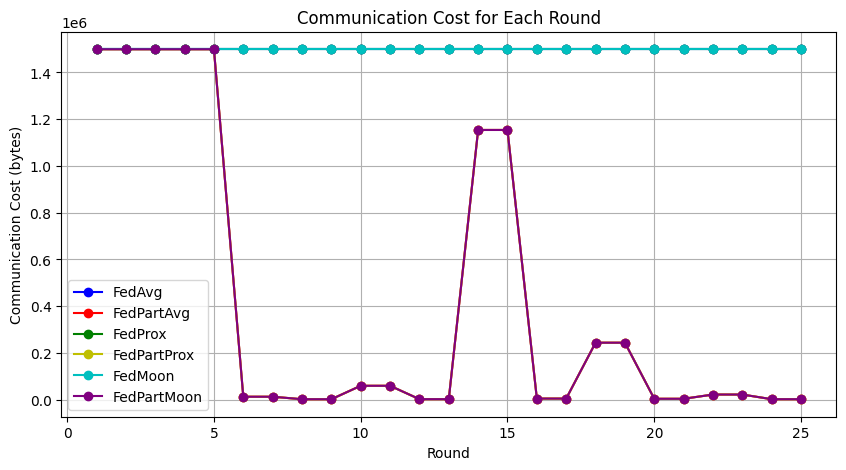

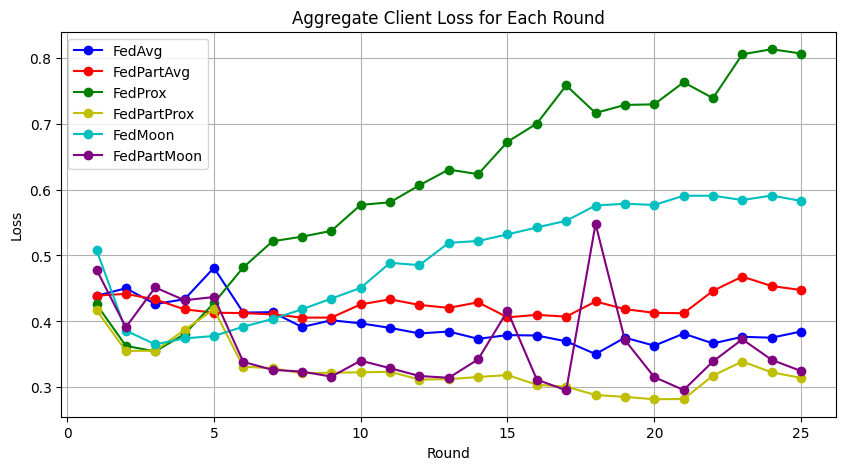

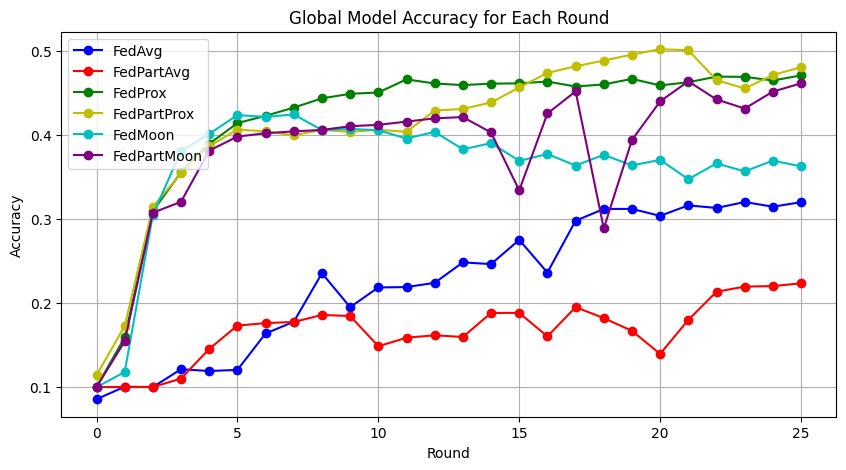

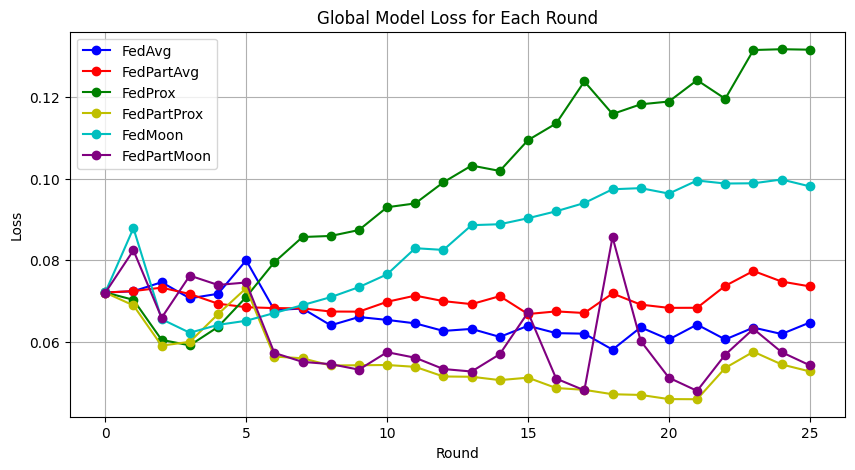

In [32]:
fed_moon_rounds = list(fed_moon_no_freeze_result.keys())
fed_moon_sizes = [fed_moon_no_freeze_result[round]["total_size"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_rounds, fed_moon_sizes, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_rounds, fed_part_moon_sizes, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Communication Cost (bytes)')
plt.title('Communication Cost for Each Round')
plt.legend()
plt.grid(True)

fed_moon_losses = [fed_moon_no_freeze_result[round]["total_loss"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_rounds, fed_moon_losses, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_rounds, fed_part_moon_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')

plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Aggregate Client Loss for Each Round')
plt.legend()
plt.grid(True)

fed_moon_model_rounds = list(fed_moon_model_no_freeze_results.keys())
fed_moon_accuracies = [fed_moon_model_no_freeze_results[round]["global_metrics"]["accuracy"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_model_rounds, fed_prox_accuracies, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_model_rounds, fed_moon_accuracies, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_model_rounds, fed_part_moon_accuracies, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Global Model Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_moon_global_losses = [fed_moon_model_no_freeze_results[round]["global_loss"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_model_rounds, fed_prox_global_losses, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_model_rounds, fed_moon_global_losses, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_model_rounds, fed_part_moon_global_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Global Model Loss for Each Round')
plt.legend()
plt.grid(True)
